# DATA SCIENCE PROJECT 

## Regression
### Boston Housing data

In [1]:
# processing
import d6tflow, luigi, d6tpipe
import pandas as pd
import numpy as np
import pathlib

# viz
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.inspection import plot_partial_dependence
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import lightgbm
import warnings
from sklearn import metrics
#lightgbm.LGBMRegressor
import shap
#shap.initjs()

# project
# import cfg, tasks
# import importlib # optional
# importlib.reload(cfg)
# importlib.reload(tasks)
# importlib.reload(visualize)


Loading postgres module without psycopg2 installed. Will crash at runtime if postgres functionality is used.


Welcome to d6tflow!
Welcome to d6tpipe!


In [2]:
import d6tflow.pipes

d6tflow.pipes.init('intro-stat-learning',profile='default', reset=True) #, local_pipe=True
pipe = d6tflow.pipes.get_pipe()
pipe.pull()

No token provided. Register or login to connect to repo API.
Successfully connected to pipe intro-stat-learning.  Read only access
pulling: 0.00MB


0it [00:00, ?it/s]


[]

In [3]:
print('where files are stored:',pipe.dirpath)

where files are stored: C:\Users\32895\d6tpipe\files\default\intro-stat-learning


In [4]:
# tasks

class TaskProcessRawData1(d6tflow.tasks.TaskPqPandas):

    def run(self):        
        pipe=d6tpipe.PipeLocal('intro-stat-learning')
        df = pd.read_csv(pipe.dirpath/'boston_housing.csv',index_col=0)
        self.save(df)

@d6tflow.requires(TaskProcessRawData1)
class TaskFeatures(d6tflow.tasks.TaskPqPandas):
    factorize = luigi.BoolParameter(default=True)
    
    def run(self):
        df = self.inputLoad()
        if self.factorize:
            for col in ['CHAS','RAD']:
                df[col]=df[col].factorize()[0]
        df['target']=df['MEDV']
        df = df.dropna()
        self.save(df)

In [5]:
d6tflow.run([TaskFeatures()],forced_all=True,confirm=False)
df_train = TaskFeatures().outputLoad()

INFO: Informed scheduler that task   TaskFeatures_True_e0eded0c4b   has status   PENDING
INFO:luigi-interface:Informed scheduler that task   TaskFeatures_True_e0eded0c4b   has status   PENDING
INFO: Informed scheduler that task   TaskProcessRawData1__99914b932b   has status   DONE
INFO:luigi-interface:Informed scheduler that task   TaskProcessRawData1__99914b932b   has status   DONE
INFO: Done scheduling tasks
INFO:luigi-interface:Done scheduling tasks
INFO: Running Worker with 1 processes
INFO:luigi-interface:Running Worker with 1 processes
INFO: [pid 7800] Worker Worker(salt=510940750, workers=1, host=DESKTOP-8S61CGN, username=32895, pid=7800) running   TaskFeatures(factorize=True)
INFO:luigi-interface:[pid 7800] Worker Worker(salt=510940750, workers=1, host=DESKTOP-8S61CGN, username=32895, pid=7800) running   TaskFeatures(factorize=True)
INFO: [pid 7800] Worker Worker(salt=510940750, workers=1, host=DESKTOP-8S61CGN, username=32895, pid=7800) done      TaskFeatures(factorize=True)
IN

In [6]:
cfg_col_X_cat = ['CHAS','RAD']
cfg_col_X_num = ['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','TAX','PTRATIO','B','LSTAT']
cfg_col_X = cfg_col_X_cat+cfg_col_X_num
cfg_col_Y = 'target'
cfg_col_cat = ['CHAS','RAD']

In [7]:
df_train.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV', 'target'],
      dtype='object')

In [8]:
df_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,target
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,0,296,15.3,396.90,4.98,24.0,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,1,242,17.8,396.90,9.14,21.6,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,1,242,17.8,392.83,4.03,34.7,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,2,222,18.7,394.63,2.94,33.4,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,2,222,18.7,396.90,5.33,36.2,36.2


Boston House Price dataset has 14 features and their description is given as follows:

·CRIM per capita crime rate by town

·ZN proportion of residential land zoned for lots over 25,000 sq.ft.

·INDUS proportion of non-retail business acres per town

·CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

·NOX nitric oxides concentration (parts per 10 million)

·RM average number of rooms per dwelling

·AGE proportion of owner-occupied units built prior to 1940

·DIS weighted distances to five Boston employment centres

·RAD index of accessibility to radial highways

·TAX full-value property-tax rate per dollar 10,000.

·PTRATIO pupil-teacher ratio by town

·B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

·LSTAT % lower status of the population

·MEDV Median value of owner-occupied homes in $1000's

Here main thing to notice is that MEDV is the outcome variable which we need to predict and all other variables are predictor variables.

In [9]:
print('observations and type')
df_train.info()

observations and type
<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 0 to 505
Data columns (total 15 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
target     506 non-null float64
dtypes: float64(12), int64(3)
memory usage: 63.2 KB


In [10]:
print('missing values')
df_train.apply(lambda x: x.isna().sum()/len(x))

missing values


CRIM       0.0
ZN         0.0
INDUS      0.0
CHAS       0.0
NOX        0.0
RM         0.0
AGE        0.0
DIS        0.0
RAD        0.0
TAX        0.0
PTRATIO    0.0
B          0.0
LSTAT      0.0
MEDV       0.0
target     0.0
dtype: float64

In [11]:
print('unique values')
df_train.apply(lambda x: len(x.unique()))

unique values


CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
MEDV       229
target     229
dtype: int64

In [12]:
df_train.describe().round(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,target
count,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,4.62,408.24,18.46,356.67,12.65,22.53,22.53
std,8.60,23.32,6.86,0.25,0.12,0.70,28.15,2.11,2.44,168.54,2.16,91.29,7.14,9.20,9.20
min,0.01,0.00,0.46,0.00,0.38,3.56,2.90,1.13,0.00,187.00,12.60,0.32,1.73,5.00,5.00
25%,0.08,0.00,5.19,0.00,0.45,5.89,45.02,2.10,3.00,279.00,17.40,375.38,6.95,17.02,17.02
50%,0.26,0.00,9.69,0.00,0.54,6.21,77.50,3.21,4.00,330.00,19.05,391.44,11.36,21.20,21.20
75%,3.68,12.50,18.10,0.00,0.62,6.62,94.07,5.19,8.00,666.00,20.20,396.22,16.96,25.00,25.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,8.00,711.00,22.00,396.90,37.97,50.00,50.00


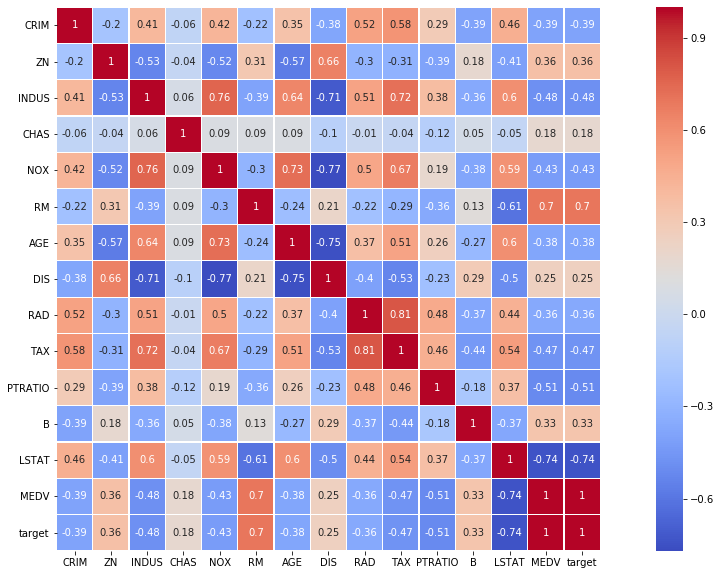

In [13]:
plt.figure(figsize=(20, 10))
sns.heatmap(data=df_train.corr().round(2),annot=True,cmap='coolwarm',linewidths=0.2,square=True)

According to heatmap.INDUS, RM, TAX, PTRATIO and LSTAT, as well as CRIM present some correlation(either positive or negative). While there exists multicollinearity e.g.:INDUS shows relatively high correlation with NOX,TAX etc.

From my perspective,I think LSTAT,RM,PTR ratio are important features.1)increase in RM value increases MEDV value ie price of the home. 2) Lower the value of LSTAT higher the value of MEDV 3) PTRATIO decrease in the value increases MEDV.

### distribution of target variable

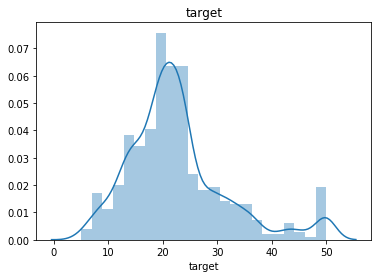

In [14]:
sns.distplot(df_train[cfg_col_Y]).set_title(cfg_col_Y);

### distribution of input variables

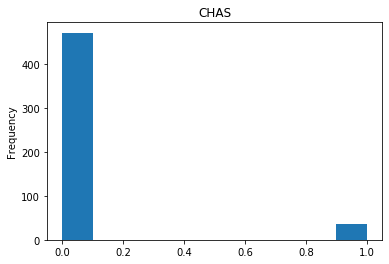

In [15]:
df_train['CHAS'].plot.hist(title='CHAS')

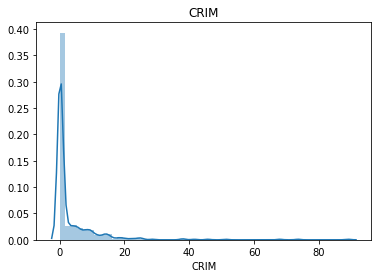

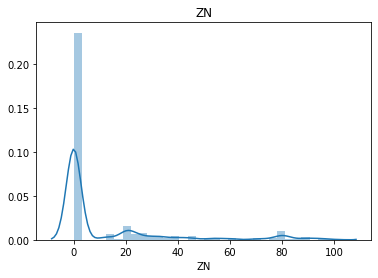

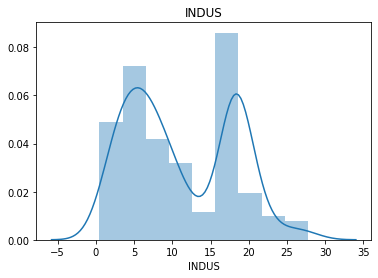

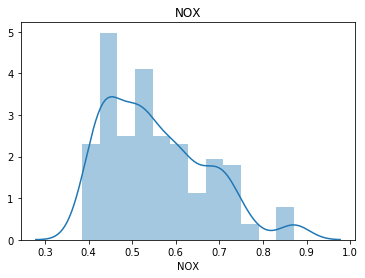

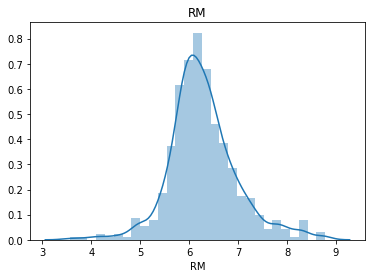

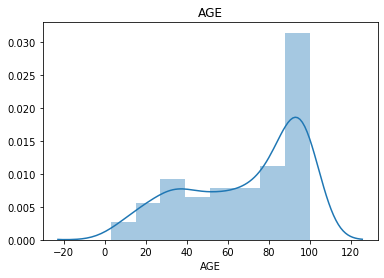

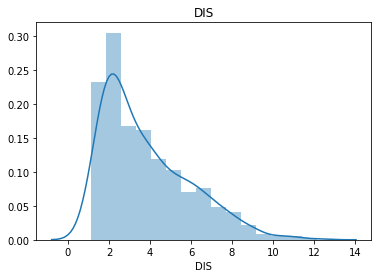

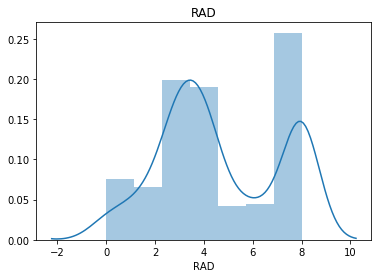

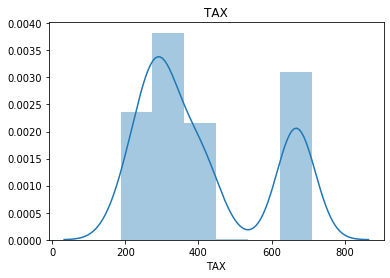

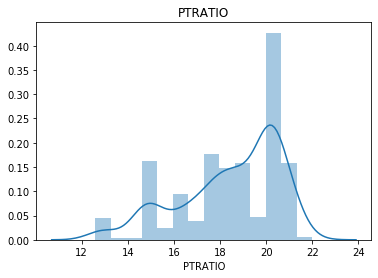

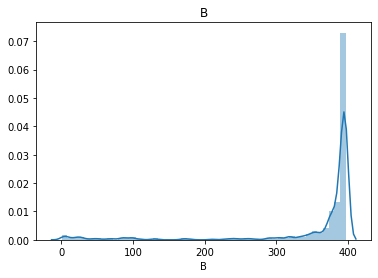

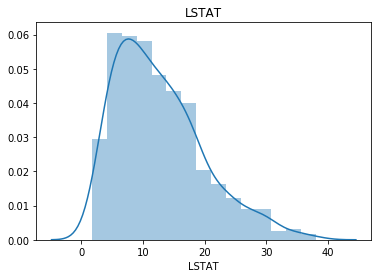

In [16]:
for icol in ['CRIM', 'ZN', 'INDUS','NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'LSTAT']:
    plt.figure();
    sns.distplot(df_train[icol]).set_title(icol);

### relation of inut variables to target variable

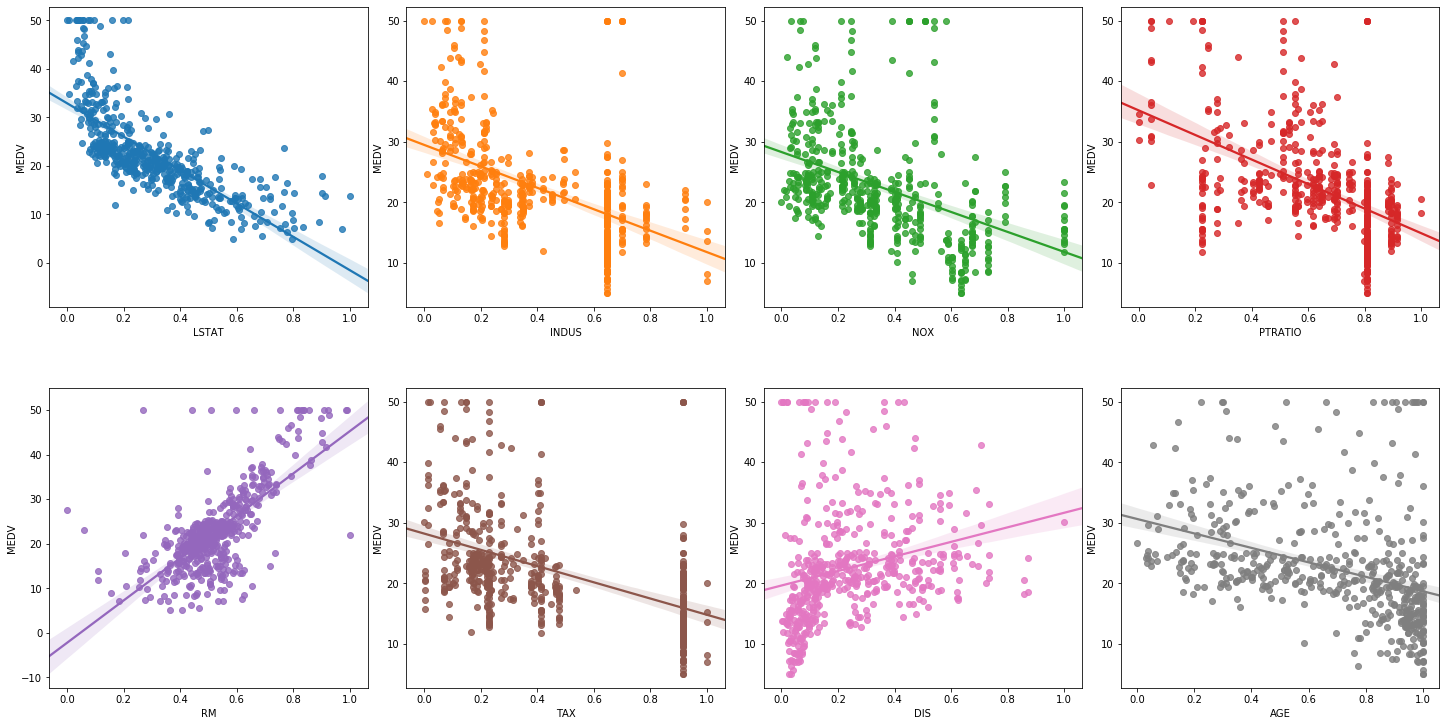

In [17]:
from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['LSTAT', 'INDUS', 'NOX', 'PTRATIO', 'RM', 'TAX', 'DIS', 'AGE']
x = df_train.loc[:,column_sels]
y = df_train['MEDV']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [18]:
for icol in cfg_col_X_cat:
    print(icol)
    print(df_train.groupby(icol)['target'].agg(['mean','count']))


CHAS
           mean  count
CHAS                  
0     22.093843    471
1     28.440000     35
RAD
          mean  count
RAD                  
0    24.365000     20
1    26.833333     24
2    27.928947     38
3    25.706957    115
4    21.387273    110
5    30.358333     24
6    20.976923     26
7    27.105882     17
8    16.403788    132


## model training

In [19]:
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(df_train[cfg_col_X], df_train[cfg_col_Y], test_size=validation_size, random_state=seed)
df_trainX, df_trainY = df_train[cfg_col_X], df_train[cfg_col_Y]

In [20]:
df_train['target_naive1']=df_train['target'].mean()

In [21]:
# Test options and evaluation metric using R2 to keep the same with automl tools
num_folds = 10
seed = 1234
RSQ = 'r2'

In [22]:
mod_ols = sm.OLS(df_trainY,sm.add_constant(df_trainX))

res_ols = mod_ols.fit()
print(res_ols.summary())
df_train['target_ols']=res_ols.predict()

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.


                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     104.2
Date:                Fri, 21 Aug 2020   Prob (F-statistic):          5.11e-132
Time:                        15:58:14   Log-Likelihood:                -1505.7
No. Observations:                 506   AIC:                             3039.
Df Residuals:                     492   BIC:                             3099.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.4857      4.999      6.298      0.0

In [23]:
from sklearn.linear_model import LinearRegression

mod_skols = LinearRegression()
mod_skols.fit(df_trainX,df_trainY)
df_train['target_skols']=mod_skols.predict(df_trainX)

In [24]:
mod_lgbm = lightgbm.LGBMRegressor(max_depth=2,learning_rate=0.1,n_estimators=100,reg_alpha=1.0)
mod_lgbm.fit(df_trainX,df_trainY)
df_train['target_lgbm']=mod_lgbm.predict(df_trainX)

# Decision tree

In [25]:
#feature engineering
cfg_col_X_cat = ['CHAS','RAD']
cfg_col_X_num = ['CRIM','NOX','RM','DIS','TAX','PTRATIO','LSTAT']
cfg_col_X = cfg_col_X_cat+cfg_col_X_num

In [26]:
X_train,X_test,y_train,y_test = train_test_split(df_train[cfg_col_X], df_train[cfg_col_Y],test_size=0.2,random_state=1234)
mod_CART = DecisionTreeRegressor(random_state=0,min_samples_split=4,max_features=9,max_depth=30)
mod_CART.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=30, max_features=9,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [27]:
y_pred = mod_CART.predict(X_test)
from sklearn import metrics
r2= metrics.r2_score(y_test,y_pred)
N,p = X_test.shape
adj_r2 = 1-((1-r2)*(N-1))/(N-p-1)
print(f'Decision Tree R2')
print(f'R^2 = {r2}')
print(f'Adjusted R^2 = {adj_r2}')

Decision Tree R2
R^2 = 0.8857501951730132
Adjusted R^2 = 0.8745735838312427


# Random Forest

In [28]:
warnings.filterwarnings(action='ignore')
mod_RF = RandomForestRegressor(random_state=0,min_samples_split=4,max_features=9,max_depth=20)
mod_RF.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features=9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [29]:
y_pred = mod_RF.predict(X_test)
r2= metrics.r2_score(y_test,y_pred)
N,p = X_test.shape
adj_r2 = 1-((1-r2)*(N-1))/(N-p-1)
print(f'Random Forest R2')
print(f'R^2 = {r2}')
print(f'Adjusted R^2 = {adj_r2}')

Random Forest R2
R^2 = 0.9186932175509765
Adjusted R^2 = 0.9107392931809634


In [30]:
models=[]
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('CART', DecisionTreeRegressor(random_state=0)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('Random Forest',RandomForestRegressor(random_state=0)))
models.append(('XGBoost Random Forest',xgb.XGBRFRegressor(random_state=0)))


In [31]:
for name,model in models:
    mod=model
    mod.fit(X_train,y_train)
    y_pred=mod.predict(X_test)
    r2= metrics.r2_score(y_test,y_pred)
    N,p = X_test.shape
    adj_r2 = 1-((1-r2)*(N-1))/(N-p-1)
    print(name,f'R2')
    print(f'R^2 = {r2}')
    print(f'Adjusted R^2 = {adj_r2}')
    print('--------------------------------------------------')

LR R2
R^2 = 0.7794858711792204
Adjusted R^2 = 0.7579138368380571
--------------------------------------------------
LASSO R2
R^2 = 0.6850108663267511
Adjusted R^2 = 0.6541967119456724
--------------------------------------------------
CART R2
R^2 = 0.8853219419287515
Adjusted R^2 = 0.8741034362478685
--------------------------------------------------
KNN R2
R^2 = 0.7893028548938666
Adjusted R^2 = 0.7686911776552232
--------------------------------------------------
Random Forest R2
R^2 = 0.9131716902766367
Adjusted R^2 = 0.9046776164993512
--------------------------------------------------
XGBoost Random Forest R2
R^2 = 0.9029427331626289
Adjusted R^2 = 0.8934480005372338
--------------------------------------------------


# After tuning

In [32]:
warnings.filterwarnings(action='ignore')
mod_RF = KNeighborsRegressor(leaf_size=50,n_neighbors=3,p=2,metric='minkowski')
mod_RF.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=50, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [33]:
y_pred = mod_RF.predict(X_test)
r2= metrics.r2_score(y_test,y_pred)
N,p = X_test.shape
adj_r2 = 1-((1-r2)*(N-1))/(N-p-1)
print(f'Random Forest R2')
print(f'R^2 = {r2}')
print(f'Adjusted R^2 = {adj_r2}')

Random Forest R2
R^2 = 0.8185971044591087
Adjusted R^2 = 0.8008511690257607


In [34]:
models=[]
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('CART', DecisionTreeRegressor(random_state=0,min_samples_split=4,max_features=9)))
models.append(('KNN', KNeighborsRegressor(leaf_size=50,n_neighbors=3,p=2,metric='minkowski')))
models.append(('Random Forest',RandomForestRegressor(random_state=0,min_samples_split=4,max_features=9,max_depth=20)))
models.append(('XGBoost Random Forest',xgb.XGBRFRegressor(random_state=0,min_samples_split=4,max_depth=20)))


In [35]:
warnings.filterwarnings(action='ignore')
for name,model in models:
    mod=model
    mod.fit(X_train,y_train)
    y_pred=mod.predict(X_test)
    r2= metrics.r2_score(y_test,y_pred)
    N,p = X_test.shape
    adj_r2 = 1-((1-r2)*(N-1))/(N-p-1)
    print(name,f'R2')
    print(f'R^2 = {r2}')
    print(f'Adjusted R^2 = {adj_r2}')
    print('--------------------------------------------------')

LR R2
R^2 = 0.7794858711792204
Adjusted R^2 = 0.7579138368380571
--------------------------------------------------
LASSO R2
R^2 = 0.6850108663267511
Adjusted R^2 = 0.6541967119456724
--------------------------------------------------
CART R2
R^2 = 0.8857501951730132
Adjusted R^2 = 0.8745735838312427
--------------------------------------------------
KNN R2
R^2 = 0.8185971044591087
Adjusted R^2 = 0.8008511690257607
--------------------------------------------------
Random Forest R2
R^2 = 0.9186932175509765
Adjusted R^2 = 0.9107392931809634
--------------------------------------------------
[15:58:15] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost 

## model evaluation
### prediction errors: in-sample

In [36]:
from sklearn.metrics import mean_squared_error
print('naive mean',mean_squared_error(df_train[cfg_col_Y],df_train['target_naive1']))
print('ols',mean_squared_error(df_train[cfg_col_Y],df_train['target_skols']))
print('gbm',mean_squared_error(df_train[cfg_col_Y],df_train['target_lgbm']))

naive mean 84.41955615616554
ols 22.498115387777307
gbm 6.74207188456887


### prediction errors: cross-validation

In [37]:
print('ols',-cross_validate(mod_skols, df_trainX, df_trainY, return_train_score=False, scoring=('r2', 'neg_mean_squared_error'), cv=10)['test_neg_mean_squared_error'].mean())
print('gbm',-cross_validate(mod_lgbm, df_trainX, df_trainY, return_train_score=False, scoring=('r2', 'neg_mean_squared_error'), cv=10)['test_neg_mean_squared_error'].mean())

ols 35.226694202780536
gbm 20.496549603742576


In [38]:
for name,model in models:
    mod=model
    mod.fit(X_train,y_train)
    y_pred=mod.predict(X_test)
    print(name+' MSE',-cross_validate(mod, df_trainX, df_trainY, return_train_score=False, 
    scoring=('r2', 'neg_mean_squared_error'), cv=10)['test_neg_mean_squared_error'].mean())
    print('--------------------------------------------------')
    

LR MSE 35.226694202780536
--------------------------------------------------
LASSO MSE 35.87796543876441
--------------------------------------------------
CART MSE 36.91422399782135
--------------------------------------------------
KNN MSE 106.28859324618733
--------------------------------------------------
Random Forest MSE 24.281946843783565
--------------------------------------------------
[15:58:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:58:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters

In [39]:
results = []
names = []
num_folds = 10
seed = 7
R2 = 'r2'
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=R2)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print('--------------------------------------------------')

LR: -0.083174 (0.070546)
--------------------------------------------------
LASSO: -0.039013 (0.058747)
--------------------------------------------------
CART: -1.193729 (0.649308)
--------------------------------------------------
KNN: -0.482058 (0.330119)
--------------------------------------------------
Random Forest: -0.370988 (0.232316)
--------------------------------------------------
[15:58:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:58:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { min_samples_split } might not be used.

  This may not be accurate due to some parameters ar

In [40]:
for name,model in models:
    mod=model
    mod.fit(X_train,y_train)
    y_pred=mod.predict(X_test)
    mse = metrics.mean_squared_error(y_test,y_pred)
    mae = metrics.mean_absolute_error(y_test,y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
    print(name,f'Evaluation')
    print(f'Mean Squared Error: {mse}',f'Mean Absolute Error: {mae}',f'Root Mean Squared Error: {rmse}',sep='\n')
    print('--------------------------------------------------')

LR Evaluation
Mean Squared Error: 22.635517590676557
Mean Absolute Error: 3.6048077754965564
Root Mean Squared Error: 4.7576798537392735
--------------------------------------------------
LASSO Evaluation
Mean Squared Error: 32.333266418169394
Mean Absolute Error: 4.089239578344186
Root Mean Squared Error: 5.686234819119713
--------------------------------------------------
CART Evaluation
Mean Squared Error: 11.727608932461871
Mean Absolute Error: 2.628758169934641
Root Mean Squared Error: 3.424559669864415
--------------------------------------------------
KNN Evaluation
Mean Squared Error: 18.620795206971675
Mean Absolute Error: 3.0892156862745095
Root Mean Squared Error: 4.315181943669545
--------------------------------------------------
Random Forest Evaluation
Mean Squared Error: 8.34604618855042
Mean Absolute Error: 1.9966013071895423
Root Mean Squared Error: 2.888952437917665
--------------------------------------------------
[15:58:21] WARNING: C:\Users\Administrator\workspac

## model interpretation

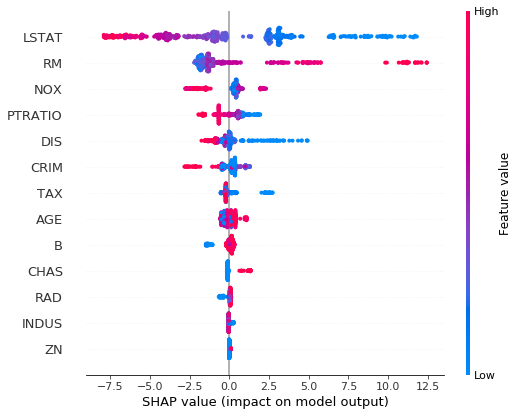

In [41]:
explainer = shap.TreeExplainer(mod_lgbm, df_trainX)
shap_values = explainer.shap_values(df_trainX)

shap.summary_plot(shap_values, df_trainX)


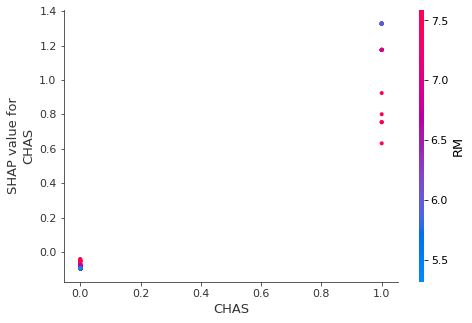

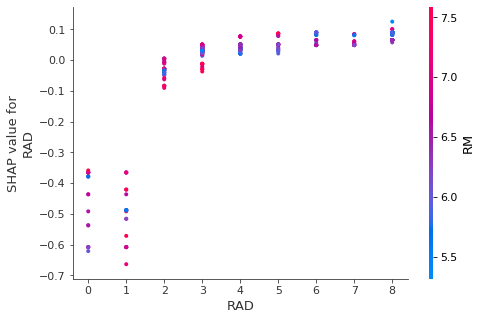

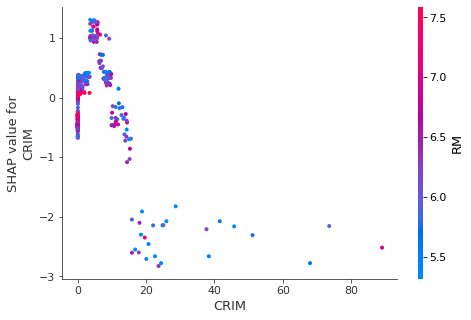

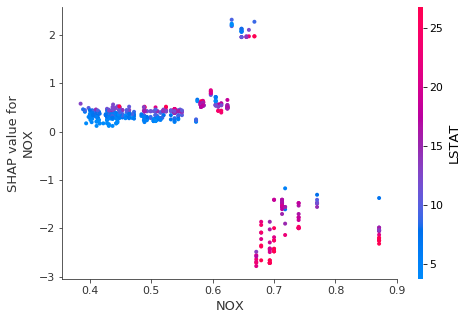

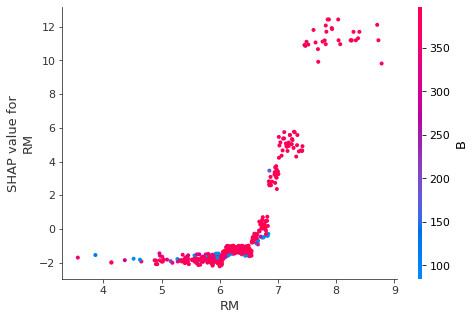

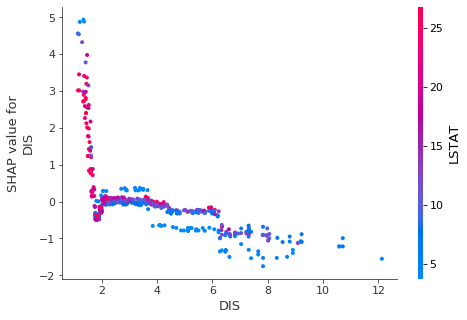

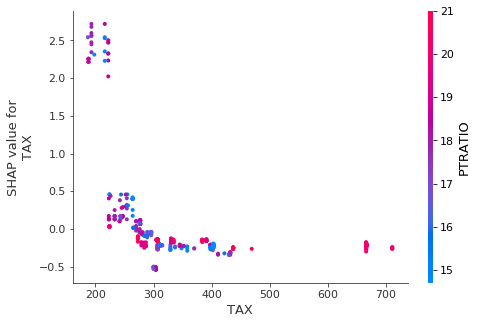

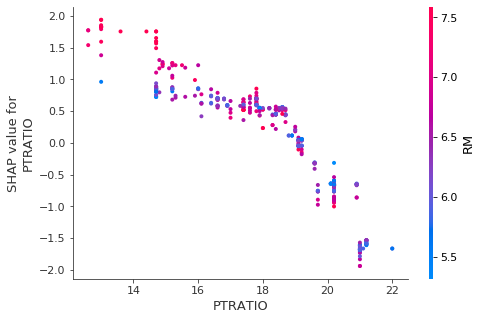

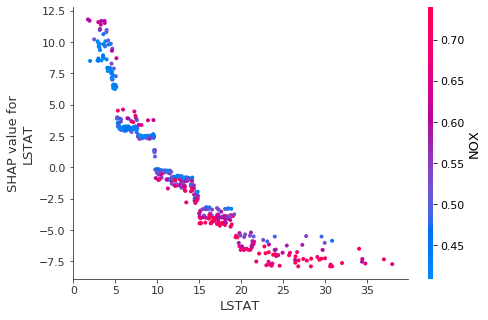

In [42]:
for col in cfg_col_X:
    shap.dependence_plot(col, shap_values, df_trainX)#,interaction_index=None)

In [43]:
dict(zip(cfg_col_X,range(len(cfg_col_X))))

{'CHAS': 0,
 'RAD': 1,
 'CRIM': 2,
 'NOX': 3,
 'RM': 4,
 'DIS': 5,
 'TAX': 6,
 'PTRATIO': 7,
 'LSTAT': 8}

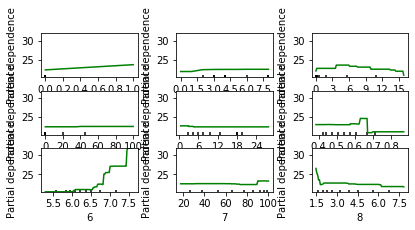

In [44]:
plot_partial_dependence(mod_lgbm, df_trainX, range(len(cfg_col_X))) 

In [45]:
features=[0,1,2,3,4,5,6,7,8,9,10,11,12]
names=['CRIM','ZN','INDUS','NOX','RM','AGE','DIS','TAX','PTRATIO','B','LSTAT','CHAS','RAD']

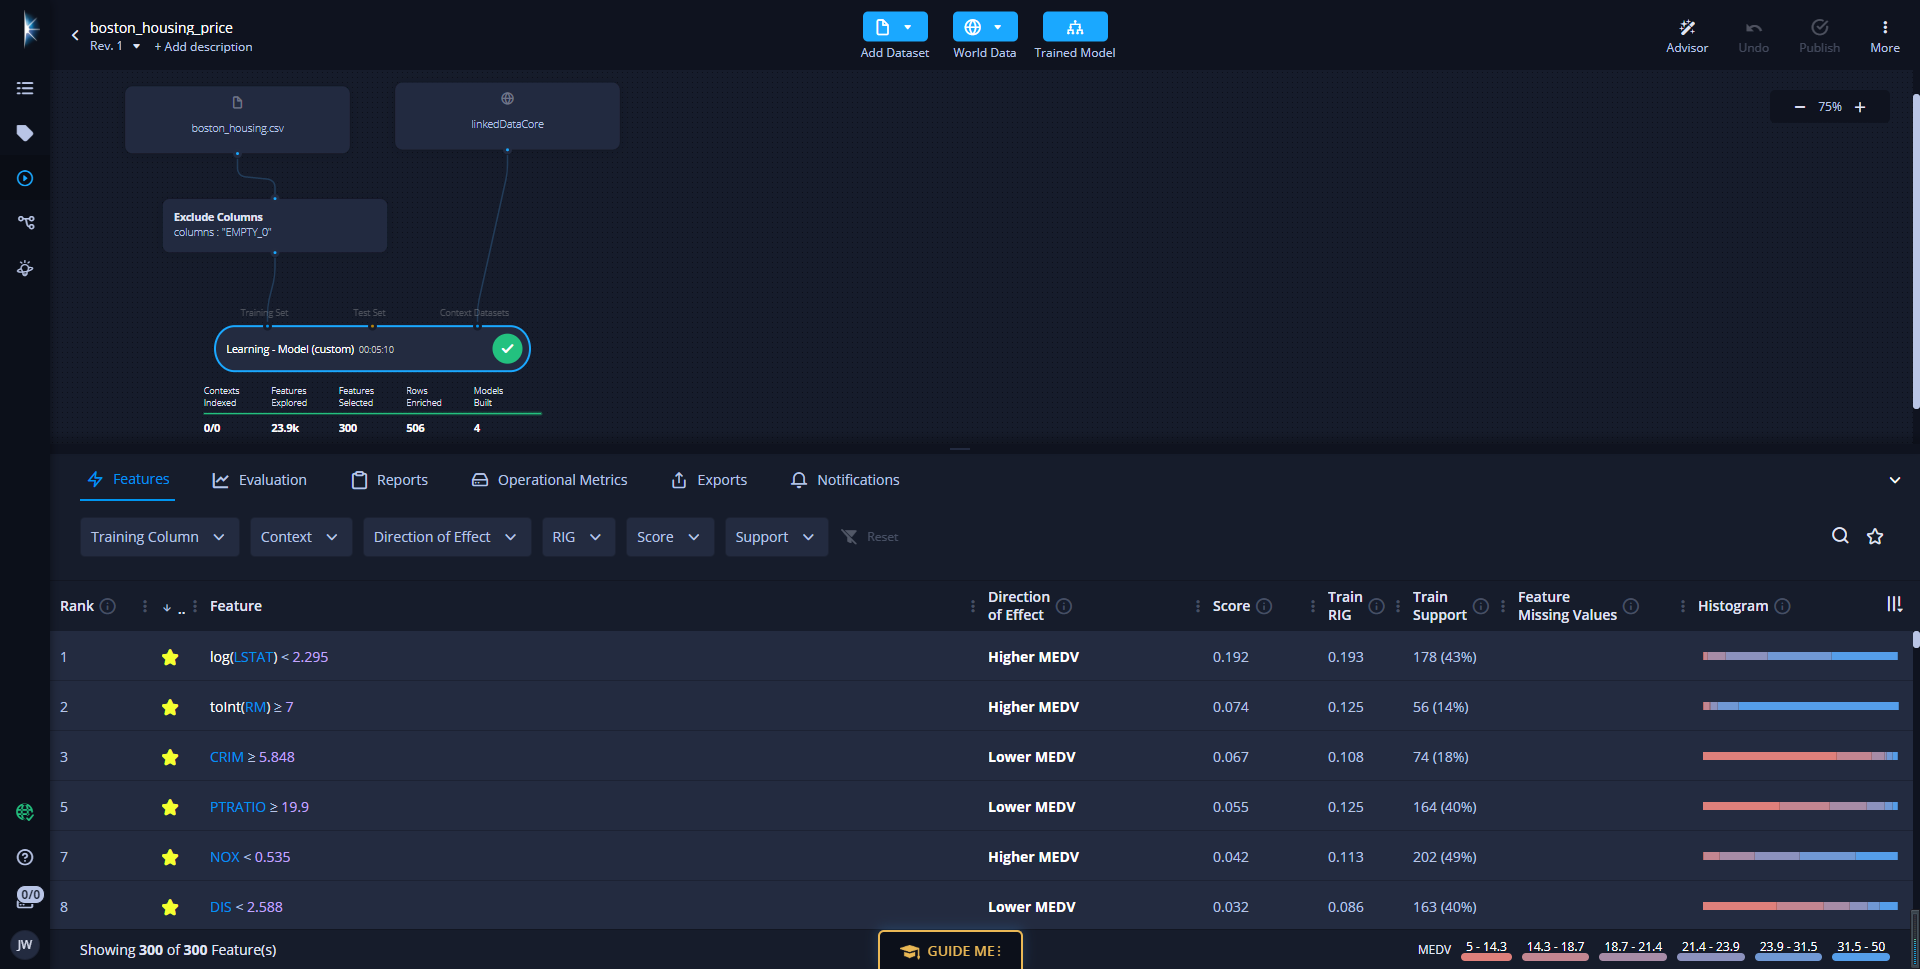

In [46]:
from IPython.display import Image
Image(filename = 'C:/Users/32895/Downloads/Boston_housing_sparkbeyond.png', width=1000, height=600)

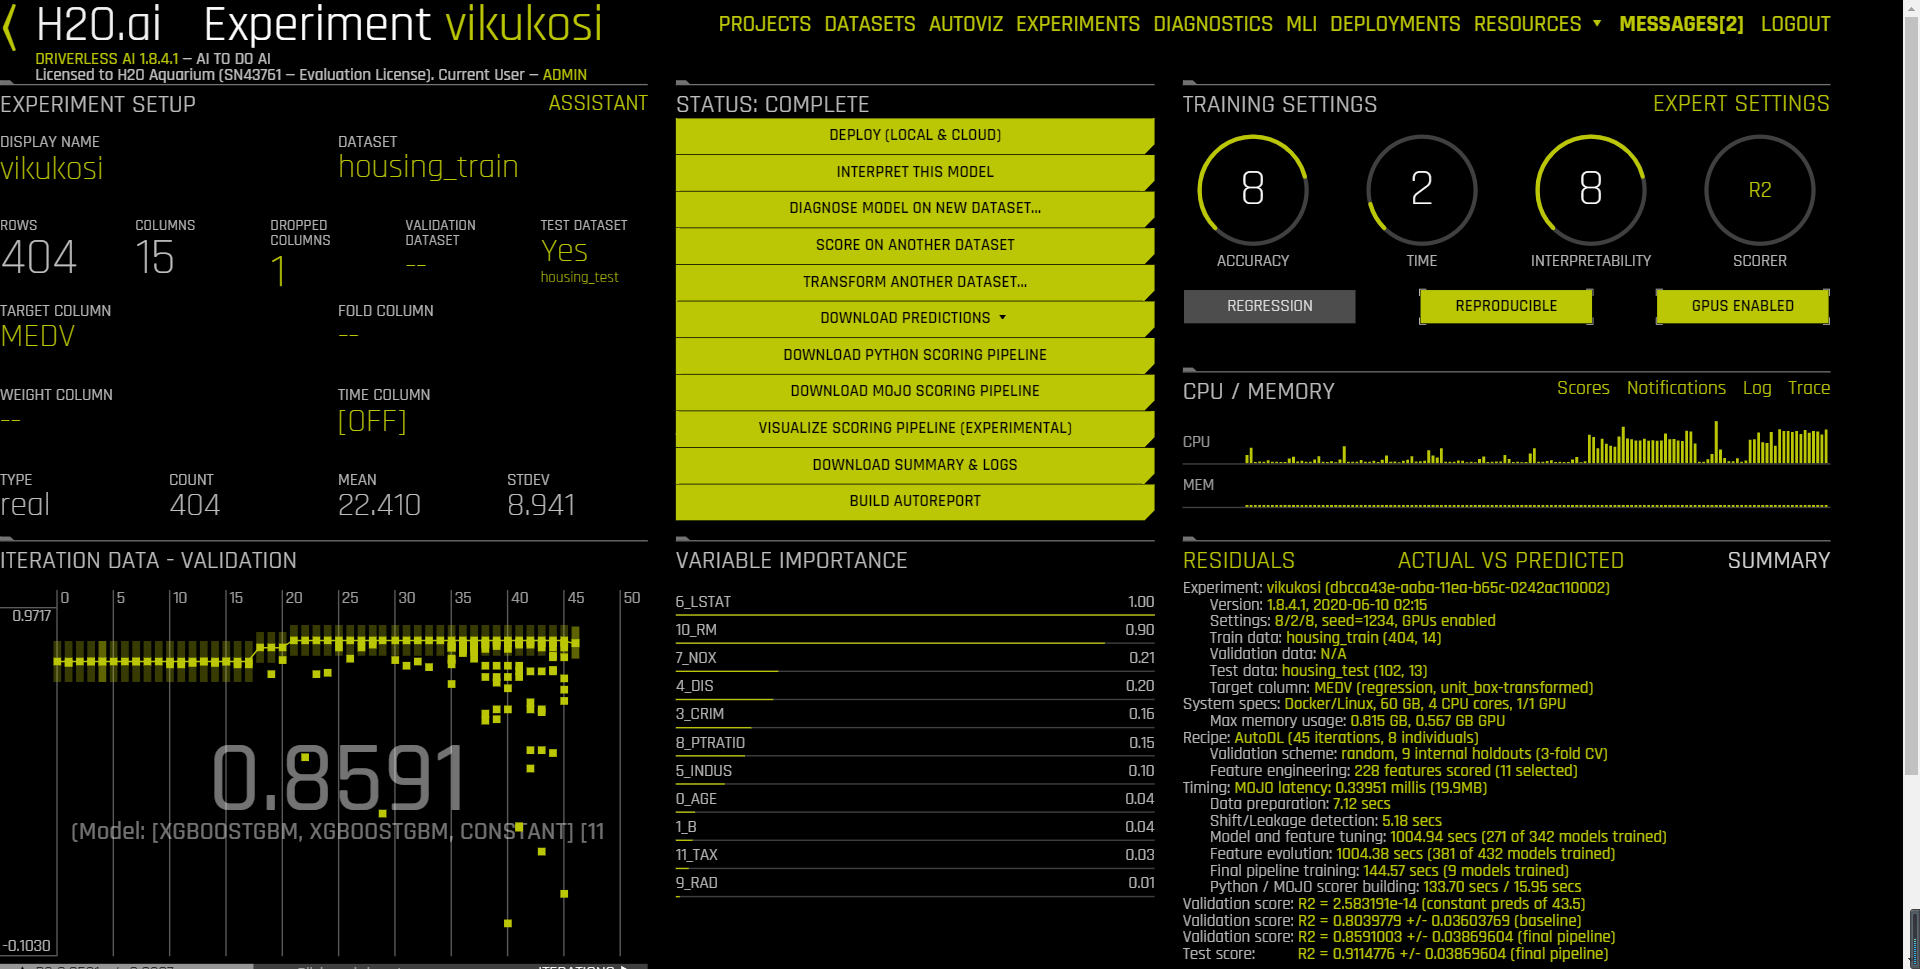

In [47]:
Image(filename = 'C:/Users/32895/Downloads/Boston_housing_h2o.png', width=1000, height=600)

# Classification on imbalanced data

## Setup

In [48]:
import tensorflow as tf
tf.enable_eager_execution() 
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [49]:
import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from numpy import random,mat,eye

In [50]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set



In [51]:
file = tf.keras.utils
raw_df = pd.read_csv('UCI_Credit_Card.csv')
raw_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [52]:
raw_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [53]:
neg, pos = np.bincount(raw_df['default.payment.next.month'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 30000
    Positive: 6636 (22.12% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [54]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('ID')

# The `Amount` column covers a huge range. Convert to log-space.
eps=0.001 # 0 => 0.1¢


Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [55]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('default.payment.next.month'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('default.payment.next.month'))
test_labels = np.array(test_df.pop('default.payment.next.month'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [56]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)



print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (19200,)
Validation labels shape: (4800,)
Test labels shape: (6000,)
Training features shape: (19200, 23)
Validation features shape: (4800, 23)
Test features shape: (6000, 23)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution



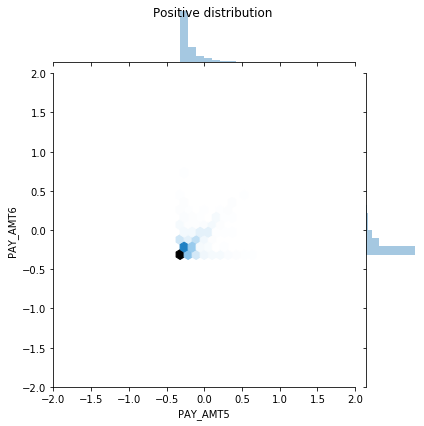

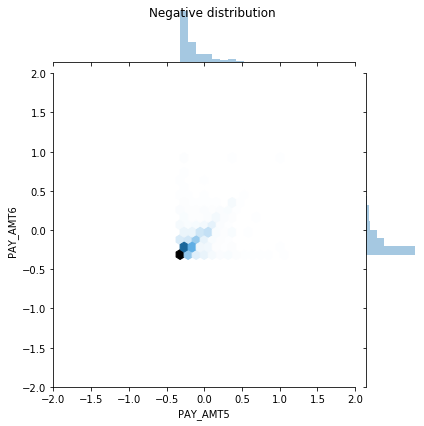

In [57]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns = train_df.columns)

sns.jointplot(pos_df['PAY_AMT5'], pos_df['PAY_AMT6'],
              kind='hex', xlim = (-2,2), ylim = (-2,2))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['PAY_AMT5'], neg_df['PAY_AMT6'],
              kind='hex', xlim = (-2,2), ylim = (-2,2))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [58]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [59]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [60]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                384       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


Test run the model:

In [61]:
model.predict(train_features[:10])

array([[0.8382708 ],
       [0.7959119 ],
       [0.66172963],
       [0.7714211 ],
       [0.8496444 ],
       [0.82803404],
       [0.8242347 ],
       [0.90719956],
       [0.8454763 ],
       [0.8202694 ]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [62]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.4011


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [63]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.258687])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [64]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.08073545],
       [0.1493037 ],
       [0.07926017],
       [0.18131816],
       [0.37657487],
       [0.30409315],
       [0.3354844 ],
       [0.22401175],
       [0.14192213],
       [0.21133056]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [65]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5320


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [66]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [67]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [68]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [69]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  
  plt.legend()

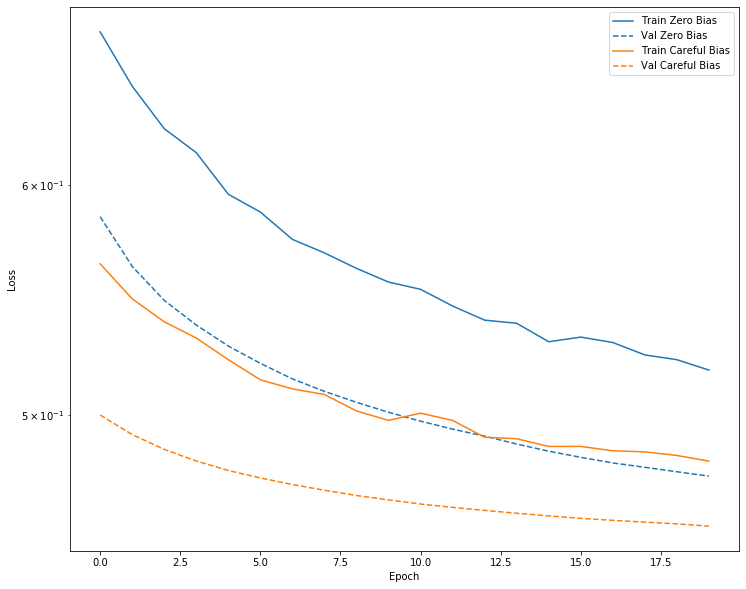

In [70]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [71]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Train on 19200 samples, validate on 4800 samples
Epoch 1/100
19200/19200 [==============================] - ETA: 3s - loss: 0.5807 - tp: 32.0000 - fp: 67.0000 - tn: 1515.0000 - fn: 434.0000 - accuracy: 0.7554 - precision: 0.3232 - recall: 0.0687 - auc: 0.56 - ETA: 0s - loss: 0.5648 - tp: 269.0000 - fp: 501.0000 - tn: 12263.0000 - fn: 3351.0000 - accuracy: 0.7649 - precision: 0.3494 - recall: 0.0743 - auc: 0.57 - 2s 90us/sample - loss: 0.5673 - tp: 308.0000 - fp: 593.0000 - tn: 14355.0000 - fn: 3944.0000 - accuracy: 0.7637 - precision: 0.3418 - recall: 0.0724 - auc: 0.5700 - val_loss: 0.5001 - val_tp: 19.0000 - val_fp: 12.0000 - val_tn: 3769.0000 - val_fn: 1000.0000 - val_accuracy: 0.7892 - val_precision: 0.6129 - val_recall: 0.0186 - val_auc: 0.6397
Epoch 2/100
19200/19200 [==============================] - ETA: 0s - loss: 0.5645 - tp: 34.0000 - fp: 56.0000 - tn: 1532.0000 - fn: 426.0000 - accuracy: 0.7646 - precision: 0.3778 - recall: 0.0739 - auc: 0.56 - ETA: 0s - loss: 0.5496 - tp: 

19200/19200 [==============================] - ETA: 0s - loss: 0.4850 - tp: 65.0000 - fp: 34.0000 - tn: 1576.0000 - fn: 373.0000 - accuracy: 0.8013 - precision: 0.6566 - recall: 0.1484 - auc: 0.67 - ETA: 0s - loss: 0.4934 - tp: 539.0000 - fp: 331.0000 - tn: 12432.0000 - fn: 3082.0000 - accuracy: 0.7917 - precision: 0.6195 - recall: 0.1489 - auc: 0.67 - 0s 5us/sample - loss: 0.4940 - tp: 626.0000 - fp: 387.0000 - tn: 14561.0000 - fn: 3626.0000 - accuracy: 0.7910 - precision: 0.6180 - recall: 0.1472 - auc: 0.6736 - val_loss: 0.4644 - val_tp: 136.0000 - val_fp: 64.0000 - val_tn: 3717.0000 - val_fn: 883.0000 - val_accuracy: 0.8027 - val_precision: 0.6800 - val_recall: 0.1335 - val_auc: 0.7082
Epoch 13/100
19200/19200 [==============================] - ETA: 0s - loss: 0.5151 - tp: 68.0000 - fp: 48.0000 - tn: 1525.0000 - fn: 407.0000 - accuracy: 0.7778 - precision: 0.5862 - recall: 0.1432 - auc: 0.66 - ETA: 0s - loss: 0.4922 - tp: 480.0000 - fp: 305.0000 - tn: 10864.0000 - fn: 2687.0000 - ac

Epoch 24/100
19200/19200 [==============================] - ETA: 0s - loss: 0.4997 - tp: 68.0000 - fp: 46.0000 - tn: 1536.0000 - fn: 398.0000 - accuracy: 0.7832 - precision: 0.5965 - recall: 0.1459 - auc: 0.68 - ETA: 0s - loss: 0.4792 - tp: 638.0000 - fp: 358.0000 - tn: 12408.0000 - fn: 2980.0000 - accuracy: 0.7963 - precision: 0.6406 - recall: 0.1763 - auc: 0.70 - 0s 5us/sample - loss: 0.4787 - tp: 757.0000 - fp: 417.0000 - tn: 14531.0000 - fn: 3495.0000 - accuracy: 0.7962 - precision: 0.6448 - recall: 0.1780 - auc: 0.7060 - val_loss: 0.4554 - val_tp: 190.0000 - val_fp: 88.0000 - val_tn: 3693.0000 - val_fn: 829.0000 - val_accuracy: 0.8090 - val_precision: 0.6835 - val_recall: 0.1865 - val_auc: 0.7245
Epoch 25/100
19200/19200 [==============================] - ETA: 0s - loss: 0.4711 - tp: 78.0000 - fp: 43.0000 - tn: 1563.0000 - fn: 364.0000 - accuracy: 0.8013 - precision: 0.6446 - recall: 0.1765 - auc: 0.71 - ETA: 0s - loss: 0.4766 - tp: 559.0000 - fp: 318.0000 - tn: 10888.0000 - fn: 2

Epoch 36/100
19200/19200 [==============================] - ETA: 0s - loss: 0.4792 - tp: 67.0000 - fp: 46.0000 - tn: 1552.0000 - fn: 383.0000 - accuracy: 0.7905 - precision: 0.5929 - recall: 0.1489 - auc: 0.70 - ETA: 0s - loss: 0.4731 - tp: 654.0000 - fp: 366.0000 - tn: 12390.0000 - fn: 2974.0000 - accuracy: 0.7961 - precision: 0.6412 - recall: 0.1803 - auc: 0.71 - 0s 5us/sample - loss: 0.4726 - tp: 775.0000 - fp: 430.0000 - tn: 14518.0000 - fn: 3477.0000 - accuracy: 0.7965 - precision: 0.6432 - recall: 0.1823 - auc: 0.7152 - val_loss: 0.4515 - val_tp: 204.0000 - val_fp: 92.0000 - val_tn: 3689.0000 - val_fn: 815.0000 - val_accuracy: 0.8110 - val_precision: 0.6892 - val_recall: 0.2002 - val_auc: 0.7307
Epoch 37/100
19200/19200 [==============================] - ETA: 0s - loss: 0.4420 - tp: 72.0000 - fp: 41.0000 - tn: 1601.0000 - fn: 334.0000 - accuracy: 0.8169 - precision: 0.6372 - recall: 0.1773 - auc: 0.72 - ETA: 0s - loss: 0.4684 - tp: 713.0000 - fp: 364.0000 - tn: 12410.0000 - fn: 2

19200/19200 [==============================] - ETA: 0s - loss: 0.4640 - tp: 104.0000 - fp: 56.0000 - tn: 1540.0000 - fn: 348.0000 - accuracy: 0.8027 - precision: 0.6500 - recall: 0.2301 - auc: 0.729 - ETA: 0s - loss: 0.4662 - tp: 661.0000 - fp: 353.0000 - tn: 10810.0000 - fn: 2512.0000 - accuracy: 0.8002 - precision: 0.6519 - recall: 0.2083 - auc: 0.73 - 0s 6us/sample - loss: 0.4671 - tp: 877.0000 - fp: 477.0000 - tn: 14471.0000 - fn: 3375.0000 - accuracy: 0.7994 - precision: 0.6477 - recall: 0.2063 - auc: 0.7289 - val_loss: 0.4484 - val_tp: 222.0000 - val_fp: 103.0000 - val_tn: 3678.0000 - val_fn: 797.0000 - val_accuracy: 0.8125 - val_precision: 0.6831 - val_recall: 0.2179 - val_auc: 0.7347
Epoch 48/100
19200/19200 [==============================] - ETA: 0s - loss: 0.4645 - tp: 88.0000 - fp: 43.0000 - tn: 1561.0000 - fn: 356.0000 - accuracy: 0.8052 - precision: 0.6718 - recall: 0.1982 - auc: 0.71 - ETA: 0s - loss: 0.4662 - tp: 764.0000 - fp: 405.0000 - tn: 12380.0000 - fn: 2835.0000 -

19200/19200 [==============================] - ETA: 0s - loss: 0.4717 - tp: 108.0000 - fp: 54.0000 - tn: 1537.0000 - fn: 349.0000 - accuracy: 0.8032 - precision: 0.6667 - recall: 0.2363 - auc: 0.717 - ETA: 0s - loss: 0.4627 - tp: 807.0000 - fp: 407.0000 - tn: 12371.0000 - fn: 2799.0000 - accuracy: 0.8043 - precision: 0.6647 - recall: 0.2238 - auc: 0.73 - 0s 5us/sample - loss: 0.4649 - tp: 936.0000 - fp: 486.0000 - tn: 14462.0000 - fn: 3316.0000 - accuracy: 0.8020 - precision: 0.6582 - recall: 0.2201 - auc: 0.7313 - val_loss: 0.4465 - val_tp: 238.0000 - val_fp: 108.0000 - val_tn: 3673.0000 - val_fn: 781.0000 - val_accuracy: 0.8148 - val_precision: 0.6879 - val_recall: 0.2336 - val_auc: 0.7375
Epoch 59/100
19200/19200 [==============================] - ETA: 0s - loss: 0.4564 - tp: 99.0000 - fp: 43.0000 - tn: 1569.0000 - fn: 337.0000 - accuracy: 0.8145 - precision: 0.6972 - recall: 0.2271 - auc: 0.72 - ETA: 0s - loss: 0.4663 - tp: 679.0000 - fp: 375.0000 - tn: 10795.0000 - fn: 2487.0000 -

19200/19200 [==============================] - ETA: 0s - loss: 0.4675 - tp: 92.0000 - fp: 47.0000 - tn: 1556.0000 - fn: 353.0000 - accuracy: 0.8047 - precision: 0.6619 - recall: 0.2067 - auc: 0.70 - ETA: 0s - loss: 0.4639 - tp: 723.0000 - fp: 360.0000 - tn: 10769.0000 - fn: 2484.0000 - accuracy: 0.8016 - precision: 0.6676 - recall: 0.2254 - auc: 0.73 - 0s 6us/sample - loss: 0.4621 - tp: 964.0000 - fp: 484.0000 - tn: 14464.0000 - fn: 3288.0000 - accuracy: 0.8035 - precision: 0.6657 - recall: 0.2267 - auc: 0.7350 - val_loss: 0.4453 - val_tp: 232.0000 - val_fp: 109.0000 - val_tn: 3672.0000 - val_fn: 787.0000 - val_accuracy: 0.8133 - val_precision: 0.6804 - val_recall: 0.2277 - val_auc: 0.7398
Epoch 70/100
19200/19200 [==============================] - ETA: 0s - loss: 0.4583 - tp: 103.0000 - fp: 66.0000 - tn: 1545.0000 - fn: 334.0000 - accuracy: 0.8047 - precision: 0.6095 - recall: 0.2357 - auc: 0.734 - ETA: 0s - loss: 0.4605 - tp: 731.0000 - fp: 365.0000 - tn: 10821.0000 - fn: 2419.0000 -

19200/19200 [==============================] - ETA: 0s - loss: 0.4648 - tp: 105.0000 - fp: 39.0000 - tn: 1552.0000 - fn: 352.0000 - accuracy: 0.8091 - precision: 0.7292 - recall: 0.2298 - auc: 0.722 - ETA: 0s - loss: 0.4590 - tp: 766.0000 - fp: 381.0000 - tn: 10811.0000 - fn: 2378.0000 - accuracy: 0.8075 - precision: 0.6678 - recall: 0.2436 - auc: 0.73 - 0s 6us/sample - loss: 0.4626 - tp: 1033.0000 - fp: 516.0000 - tn: 14432.0000 - fn: 3219.0000 - accuracy: 0.8055 - precision: 0.6669 - recall: 0.2429 - auc: 0.7379 - val_loss: 0.4438 - val_tp: 237.0000 - val_fp: 105.0000 - val_tn: 3676.0000 - val_fn: 782.0000 - val_accuracy: 0.8152 - val_precision: 0.6930 - val_recall: 0.2326 - val_auc: 0.7411
Epoch 81/100
19200/19200 [==============================] - ETA: 0s - loss: 0.4968 - tp: 96.0000 - fp: 54.0000 - tn: 1508.0000 - fn: 390.0000 - accuracy: 0.7832 - precision: 0.6400 - recall: 0.1975 - auc: 0.72 - ETA: 0s - loss: 0.4614 - tp: 758.0000 - fp: 373.0000 - tn: 10771.0000 - fn: 2434.0000 

19200/19200 [==============================] - ETA: 0s - loss: 0.4270 - tp: 114.0000 - fp: 53.0000 - tn: 1601.0000 - fn: 280.0000 - accuracy: 0.8374 - precision: 0.6826 - recall: 0.2893 - auc: 0.750 - ETA: 0s - loss: 0.4598 - tp: 752.0000 - fp: 383.0000 - tn: 10838.0000 - fn: 2363.0000 - accuracy: 0.8085 - precision: 0.6626 - recall: 0.2414 - auc: 0.73 - 0s 5us/sample - loss: 0.4601 - tp: 1043.0000 - fp: 493.0000 - tn: 14455.0000 - fn: 3209.0000 - accuracy: 0.8072 - precision: 0.6790 - recall: 0.2453 - auc: 0.7383 - val_loss: 0.4427 - val_tp: 234.0000 - val_fp: 102.0000 - val_tn: 3679.0000 - val_fn: 785.0000 - val_accuracy: 0.8152 - val_precision: 0.6964 - val_recall: 0.2296 - val_auc: 0.7426
Epoch 92/100
19200/19200 [==============================] - ETA: 0s - loss: 0.4762 - tp: 95.0000 - fp: 57.0000 - tn: 1526.0000 - fn: 370.0000 - accuracy: 0.7915 - precision: 0.6250 - recall: 0.2043 - auc: 0.71 - ETA: 0s - loss: 0.4597 - tp: 748.0000 - fp: 369.0000 - tn: 10793.0000 - fn: 2426.0000 

### Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [72]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()


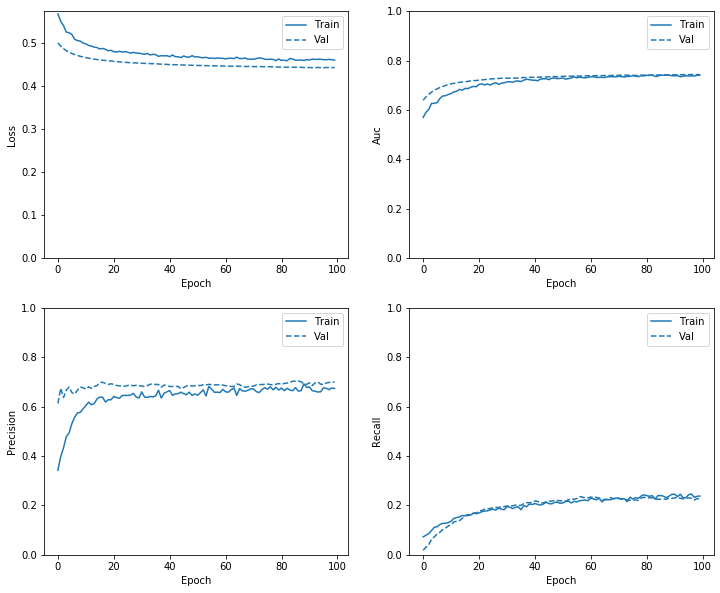

In [73]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [74]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [75]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

loss :  0.4535254724025726
tp :  356.0
fp :  128.0
tn :  4507.0
fn :  1009.0
accuracy :  0.8105
precision :  0.7355372
recall :  0.26080588
auc :  0.7451728

Legitimate Transactions Detected (True Negatives):  4507
Legitimate Transactions Incorrectly Detected (False Positives):  128
Fraudulent Transactions Missed (False Negatives):  1009
Fraudulent Transactions Detected (True Positives):  356
Total Fraudulent Transactions:  1365


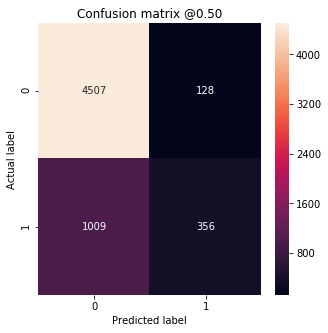

In [76]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [82]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [83]:
train_predictions_baseline

array([[0.16480854],
       [0.1452497 ],
       [0.07366577],
       ...,
       [0.19493255],
       [0.421796  ],
       [0.09342939]], dtype=float32)

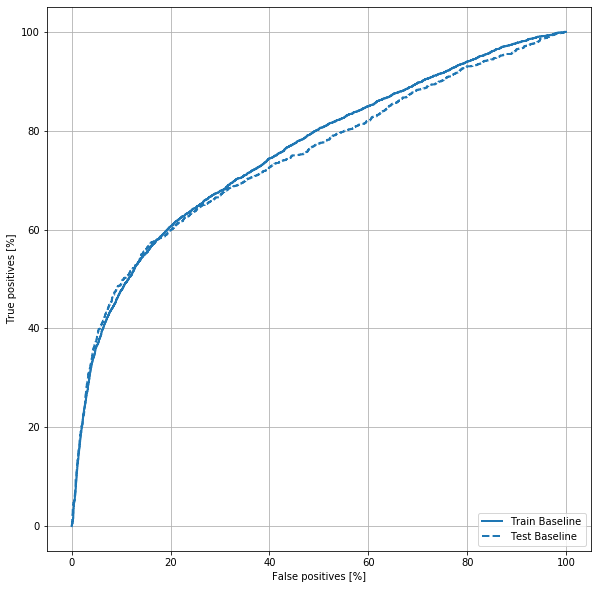

In [84]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [85]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.64
Weight for class 1: 2.26


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [86]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Train on 19200 samples, validate on 4800 samples
Epoch 1/100
19200/19200 [==============================] - ETA: 3s - loss: 0.9663 - tp: 38.0000 - fp: 79.0000 - tn: 1517.0000 - fn: 414.0000 - accuracy: 0.7593 - precision: 0.3248 - recall: 0.0841 - auc: 0.56 - ETA: 0s - loss: 0.9696 - tp: 315.0000 - fp: 711.0000 - tn: 12060.0000 - fn: 3298.0000 - accuracy: 0.7553 - precision: 0.3070 - recall: 0.0872 - auc: 0.56 - 2s 99us/sample - loss: 0.9654 - tp: 396.0000 - fp: 836.0000 - tn: 14112.0000 - fn: 3856.0000 - accuracy: 0.7556 - precision: 0.3214 - recall: 0.0931 - auc: 0.5682 - val_loss: 0.5006 - val_tp: 44.0000 - val_fp: 39.0000 - val_tn: 3742.0000 - val_fn: 975.0000 - val_accuracy: 0.7887 - val_precision: 0.5301 - val_recall: 0.0432 - val_auc: 0.6386
Epoch 2/100
19200/19200 [==============================] - ETA: 0s - loss: 0.9457 - tp: 48.0000 - fp: 87.0000 - tn: 1492.0000 - fn: 421.0000 - accuracy: 0.7520 - precision: 0.3556 - recall: 0.1023 - auc: 0.57 - ETA: 0s - loss: 0.9104 - tp: 4

19200/19200 [==============================] - ETA: 0s - loss: 0.7294 - tp: 185.0000 - fp: 347.0000 - tn: 1259.0000 - fn: 257.0000 - accuracy: 0.7051 - precision: 0.3477 - recall: 0.4186 - auc: 0.62 - ETA: 0s - loss: 0.7003 - tp: 1571.0000 - fp: 2690.0000 - tn: 10077.0000 - fn: 2046.0000 - accuracy: 0.7109 - precision: 0.3687 - recall: 0.4343 - auc: 0.65 - 0s 6us/sample - loss: 0.7000 - tp: 1855.0000 - fp: 3143.0000 - tn: 11805.0000 - fn: 2397.0000 - accuracy: 0.7115 - precision: 0.3711 - recall: 0.4363 - auc: 0.6513 - val_loss: 0.5400 - val_tp: 448.0000 - val_fp: 546.0000 - val_tn: 3235.0000 - val_fn: 571.0000 - val_accuracy: 0.7673 - val_precision: 0.4507 - val_recall: 0.4396 - val_auc: 0.7185
Epoch 13/100
19200/19200 [==============================] - ETA: 0s - loss: 0.6557 - tp: 203.0000 - fp: 315.0000 - tn: 1293.0000 - fn: 237.0000 - accuracy: 0.7305 - precision: 0.3919 - recall: 0.4614 - auc: 0.68 - ETA: 0s - loss: 0.6865 - tp: 1434.0000 - fp: 2381.0000 - tn: 8765.0000 - fn: 1756

19200/19200 [==============================] - ETA: 0s - loss: 0.6582 - tp: 207.0000 - fp: 320.0000 - tn: 1281.0000 - fn: 240.0000 - accuracy: 0.7266 - precision: 0.3928 - recall: 0.4631 - auc: 0.68 - ETA: 0s - loss: 0.6563 - tp: 1723.0000 - fp: 2680.0000 - tn: 10091.0000 - fn: 1890.0000 - accuracy: 0.7211 - precision: 0.3913 - recall: 0.4769 - auc: 0.67 - 0s 6us/sample - loss: 0.6579 - tp: 2018.0000 - fp: 3134.0000 - tn: 11814.0000 - fn: 2234.0000 - accuracy: 0.7204 - precision: 0.3917 - recall: 0.4746 - auc: 0.6780 - val_loss: 0.5509 - val_tp: 490.0000 - val_fp: 509.0000 - val_tn: 3272.0000 - val_fn: 529.0000 - val_accuracy: 0.7837 - val_precision: 0.4905 - val_recall: 0.4809 - val_auc: 0.7394
Epoch 24/100
19200/19200 [==============================] - ETA: 0s - loss: 0.6361 - tp: 241.0000 - fp: 328.0000 - tn: 1259.0000 - fn: 220.0000 - accuracy: 0.7324 - precision: 0.4236 - recall: 0.5228 - auc: 0.70 - ETA: 0s - loss: 0.6617 - tp: 1489.0000 - fp: 2337.0000 - tn: 8822.0000 - fn: 1688

19200/19200 [==============================] - ETA: 0s - loss: 0.6309 - tp: 220.0000 - fp: 328.0000 - tn: 1282.0000 - fn: 218.0000 - accuracy: 0.7334 - precision: 0.4015 - recall: 0.5023 - auc: 0.69 - ETA: 0s - loss: 0.6336 - tp: 1576.0000 - fp: 2246.0000 - tn: 8951.0000 - fn: 1563.0000 - accuracy: 0.7343 - precision: 0.4123 - recall: 0.5021 - auc: 0.697 - 0s 6us/sample - loss: 0.6391 - tp: 2120.0000 - fp: 3003.0000 - tn: 11945.0000 - fn: 2132.0000 - accuracy: 0.7326 - precision: 0.4138 - recall: 0.4986 - auc: 0.6939 - val_loss: 0.5553 - val_tp: 493.0000 - val_fp: 498.0000 - val_tn: 3283.0000 - val_fn: 526.0000 - val_accuracy: 0.7867 - val_precision: 0.4975 - val_recall: 0.4838 - val_auc: 0.7461
Epoch 35/100
19200/19200 [==============================] - ETA: 0s - loss: 0.6432 - tp: 195.0000 - fp: 266.0000 - tn: 1342.0000 - fn: 245.0000 - accuracy: 0.7505 - precision: 0.4230 - recall: 0.4432 - auc: 0.67 - ETA: 0s - loss: 0.6390 - tp: 1545.0000 - fp: 2129.0000 - tn: 9059.0000 - fn: 1603

19200/19200 [==============================] - ETA: 0s - loss: 0.6128 - tp: 217.0000 - fp: 307.0000 - tn: 1301.0000 - fn: 223.0000 - accuracy: 0.7412 - precision: 0.4141 - recall: 0.4932 - auc: 0.70 - ETA: 0s - loss: 0.6322 - tp: 1617.0000 - fp: 2023.0000 - tn: 9097.0000 - fn: 1599.0000 - accuracy: 0.7473 - precision: 0.4442 - recall: 0.5028 - auc: 0.703 - 0s 5us/sample - loss: 0.6307 - tp: 2141.0000 - fp: 2771.0000 - tn: 12177.0000 - fn: 2111.0000 - accuracy: 0.7457 - precision: 0.4359 - recall: 0.5035 - auc: 0.7020 - val_loss: 0.5592 - val_tp: 511.0000 - val_fp: 519.0000 - val_tn: 3262.0000 - val_fn: 508.0000 - val_accuracy: 0.7860 - val_precision: 0.4961 - val_recall: 0.5015 - val_auc: 0.7484
Epoch 46/100
19200/19200 [==============================] - ETA: 0s - loss: 0.6323 - tp: 217.0000 - fp: 295.0000 - tn: 1300.0000 - fn: 236.0000 - accuracy: 0.7407 - precision: 0.4238 - recall: 0.4790 - auc: 0.69 - ETA: 0s - loss: 0.6259 - tp: 1827.0000 - fp: 2332.0000 - tn: 10412.0000 - fn: 181

19200/19200 [==============================] - ETA: 0s - loss: 0.6022 - tp: 222.0000 - fp: 284.0000 - tn: 1338.0000 - fn: 204.0000 - accuracy: 0.7617 - precision: 0.4387 - recall: 0.5211 - auc: 0.72 - ETA: 0s - loss: 0.6197 - tp: 1616.0000 - fp: 1903.0000 - tn: 9236.0000 - fn: 1581.0000 - accuracy: 0.7570 - precision: 0.4592 - recall: 0.5055 - auc: 0.717 - 0s 6us/sample - loss: 0.6164 - tp: 2172.0000 - fp: 2570.0000 - tn: 12378.0000 - fn: 2080.0000 - accuracy: 0.7578 - precision: 0.4580 - recall: 0.5108 - auc: 0.7190 - val_loss: 0.5618 - val_tp: 524.0000 - val_fp: 505.0000 - val_tn: 3276.0000 - val_fn: 495.0000 - val_accuracy: 0.7917 - val_precision: 0.5092 - val_recall: 0.5142 - val_auc: 0.7492
Epoch 57/100
19200/19200 [==============================] - ETA: 0s - loss: 0.6151 - tp: 249.0000 - fp: 287.0000 - tn: 1288.0000 - fn: 224.0000 - accuracy: 0.7505 - precision: 0.4646 - recall: 0.5264 - auc: 0.72 - ETA: 0s - loss: 0.6218 - tp: 1590.0000 - fp: 1993.0000 - tn: 9178.0000 - fn: 1575

19200/19200 [==============================] - ETA: 0s - loss: 0.6249 - tp: 247.0000 - fp: 267.0000 - tn: 1309.0000 - fn: 225.0000 - accuracy: 0.7598 - precision: 0.4805 - recall: 0.5233 - auc: 0.73 - ETA: 0s - loss: 0.6161 - tp: 1616.0000 - fp: 1850.0000 - tn: 9297.0000 - fn: 1573.0000 - accuracy: 0.7612 - precision: 0.4662 - recall: 0.5067 - auc: 0.716 - 0s 6us/sample - loss: 0.6175 - tp: 2131.0000 - fp: 2509.0000 - tn: 12439.0000 - fn: 2121.0000 - accuracy: 0.7589 - precision: 0.4593 - recall: 0.5012 - auc: 0.7160 - val_loss: 0.5622 - val_tp: 535.0000 - val_fp: 506.0000 - val_tn: 3275.0000 - val_fn: 484.0000 - val_accuracy: 0.7937 - val_precision: 0.5139 - val_recall: 0.5250 - val_auc: 0.7501
Epoch 68/100
19200/19200 [==============================] - ETA: 0s - loss: 0.6198 - tp: 226.0000 - fp: 281.0000 - tn: 1322.0000 - fn: 219.0000 - accuracy: 0.7559 - precision: 0.4458 - recall: 0.5079 - auc: 0.70 - ETA: 0s - loss: 0.6141 - tp: 1845.0000 - fp: 2160.0000 - tn: 10604.0000 - fn: 177

19200/19200 [==============================] - ETA: 0s - loss: 0.6168 - tp: 231.0000 - fp: 243.0000 - tn: 1341.0000 - fn: 233.0000 - accuracy: 0.7676 - precision: 0.4873 - recall: 0.4978 - auc: 0.71 - ETA: 0s - loss: 0.6119 - tp: 1626.0000 - fp: 1854.0000 - tn: 9300.0000 - fn: 1556.0000 - accuracy: 0.7621 - precision: 0.4672 - recall: 0.5110 - auc: 0.725 - 0s 6us/sample - loss: 0.6121 - tp: 2188.0000 - fp: 2487.0000 - tn: 12461.0000 - fn: 2064.0000 - accuracy: 0.7630 - precision: 0.4680 - recall: 0.5146 - auc: 0.7255 - val_loss: 0.5649 - val_tp: 549.0000 - val_fp: 535.0000 - val_tn: 3246.0000 - val_fn: 470.0000 - val_accuracy: 0.7906 - val_precision: 0.5065 - val_recall: 0.5388 - val_auc: 0.7532
Epoch 79/100
19200/19200 [==============================] - ETA: 0s - loss: 0.6324 - tp: 222.0000 - fp: 279.0000 - tn: 1304.0000 - fn: 243.0000 - accuracy: 0.7451 - precision: 0.4431 - recall: 0.4774 - auc: 0.70 - ETA: 0s - loss: 0.6073 - tp: 1870.0000 - fp: 2141.0000 - tn: 10607.0000 - fn: 176

19200/19200 [==============================] - ETA: 0s - loss: 0.5782 - tp: 233.0000 - fp: 234.0000 - tn: 1378.0000 - fn: 203.0000 - accuracy: 0.7866 - precision: 0.4989 - recall: 0.5344 - auc: 0.75 - ETA: 0s - loss: 0.6077 - tp: 1894.0000 - fp: 2136.0000 - tn: 10625.0000 - fn: 1729.0000 - accuracy: 0.7641 - precision: 0.4700 - recall: 0.5228 - auc: 0.73 - 0s 5us/sample - loss: 0.6096 - tp: 2203.0000 - fp: 2512.0000 - tn: 12436.0000 - fn: 2049.0000 - accuracy: 0.7624 - precision: 0.4672 - recall: 0.5181 - auc: 0.7308 - val_loss: 0.5680 - val_tp: 555.0000 - val_fp: 558.0000 - val_tn: 3223.0000 - val_fn: 464.0000 - val_accuracy: 0.7871 - val_precision: 0.4987 - val_recall: 0.5447 - val_auc: 0.7561
Epoch 90/100
19200/19200 [==============================] - ETA: 0s - loss: 0.5993 - tp: 235.0000 - fp: 255.0000 - tn: 1346.0000 - fn: 212.0000 - accuracy: 0.7720 - precision: 0.4796 - recall: 0.5257 - auc: 0.73 - ETA: 0s - loss: 0.6122 - tp: 1866.0000 - fp: 2119.0000 - tn: 10621.0000 - fn: 177

19200/19200 [==============================] - ETA: 0s - loss: 0.6133 - tp: 224.0000 - fp: 303.0000 - tn: 1318.0000 - fn: 203.0000 - accuracy: 0.7529 - precision: 0.4250 - recall: 0.5246 - auc: 0.71 - ETA: 0s - loss: 0.6094 - tp: 1649.0000 - fp: 1842.0000 - tn: 9316.0000 - fn: 1529.0000 - accuracy: 0.7649 - precision: 0.4724 - recall: 0.5189 - auc: 0.734 - 0s 6us/sample - loss: 0.6062 - tp: 2224.0000 - fp: 2471.0000 - tn: 12477.0000 - fn: 2028.0000 - accuracy: 0.7657 - precision: 0.4737 - recall: 0.5230 - auc: 0.7358 - val_loss: 0.5682 - val_tp: 556.0000 - val_fp: 553.0000 - val_tn: 3228.0000 - val_fn: 463.0000 - val_accuracy: 0.7883 - val_precision: 0.5014 - val_recall: 0.5456 - val_auc: 0.7566


### Check training history

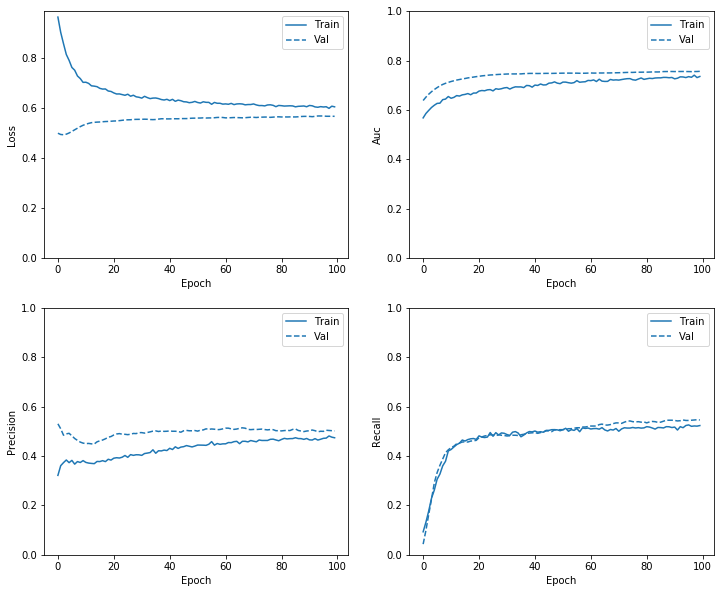

In [87]:
plot_metrics(weighted_history)

### Evaluate metrics

In [88]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.565423391977946
tp :  757.0
fp :  688.0
tn :  3947.0
fn :  608.0
accuracy :  0.784
precision :  0.5238754
recall :  0.5545788
auc :  0.7576874

Legitimate Transactions Detected (True Negatives):  3947
Legitimate Transactions Incorrectly Detected (False Positives):  688
Fraudulent Transactions Missed (False Negatives):  608
Fraudulent Transactions Detected (True Positives):  757
Total Fraudulent Transactions:  1365


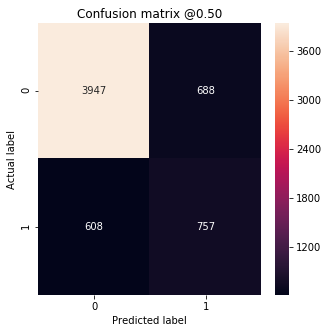

In [89]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

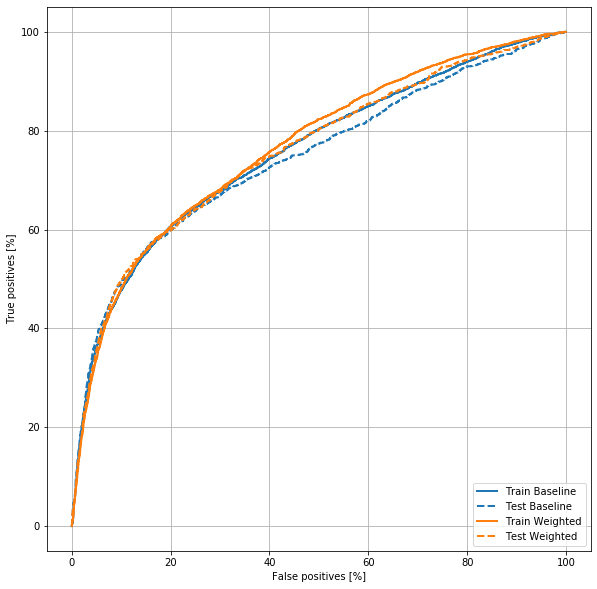

In [90]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [91]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [92]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(14948, 23)

In [93]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(29896, 23)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [94]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [95]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-0.28699342  0.80546651  0.18585203  0.86312469  0.92895714  1.78445389
  0.11001479  0.14291802  1.91163728  2.00314166  1.99189745  0.27839005
  0.32805514  0.45301909  0.56050545  0.66286898  0.73410483 -0.17688879
  0.03875606 -0.11351726 -0.08481299 -0.10503509 -0.10965102]

Label:  1


Merge the two together using `experimental.sample_from_datasets`:

In [96]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [97]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.49609375


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [98]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

23.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [99]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Epoch 1/100
23/23 [==============================] - ETA: 50s - loss: 0.7725 - tp: 449.0000 - fp: 369.0000 - tn: 663.0000 - fn: 567.0000 - accuracy: 0.5430 - precision: 0.5489 - recall: 0.4419 - auc: 0.55 - ETA: 11s - loss: 0.7712 - tp: 1808.0000 - fp: 1516.0000 - tn: 2611.0000 - fn: 2257.0000 - accuracy: 0.5394 - precision: 0.5439 - recall: 0.4448 - auc: 0.56 - ETA: 6s - loss: 0.7678 - tp: 2767.0000 - fp: 2286.0000 - tn: 3875.0000 - fn: 3360.0000 - accuracy: 0.5405 - precision: 0.5476 - recall: 0.4516 - auc: 0.5622 - ETA: 4s - loss: 0.7638 - tp: 3785.0000 - fp: 3011.0000 - tn: 5147.0000 - fn: 4441.0000 - accuracy: 0.5452 - precision: 0.5569 - recall: 0.4601 - auc: 0.566 - ETA: 3s - loss: 0.7601 - tp: 4794.0000 - fp: 3794.0000 - tn: 6397.0000 - fn: 5495.0000 - accuracy: 0.5464 - precision: 0.5582 - recall: 0.4659 - auc: 0.568 - ETA: 2s - loss: 0.7567 - tp: 5836.0000 - fp: 4551.0000 - tn: 7631.0000 - fn: 6558.0000 - accuracy: 0.5480 - precision: 0.5619 - recall: 0.4709 - auc: 0.571 - ET

23/23 [==============================] - ETA: 0s - loss: 0.6685 - tp: 659.0000 - fp: 469.0000 - tn: 566.0000 - fn: 354.0000 - accuracy: 0.5981 - precision: 0.5842 - recall: 0.6505 - auc: 0.654 - ETA: 0s - loss: 0.6588 - tp: 2001.0000 - fp: 1298.0000 - tn: 1770.0000 - fn: 1075.0000 - accuracy: 0.6138 - precision: 0.6065 - recall: 0.6505 - auc: 0.664 - ETA: 0s - loss: 0.6604 - tp: 3242.0000 - fp: 2194.0000 - tn: 2999.0000 - fn: 1805.0000 - accuracy: 0.6095 - precision: 0.5964 - recall: 0.6424 - auc: 0.659 - ETA: 0s - loss: 0.6597 - tp: 4595.0000 - fp: 3063.0000 - tn: 4160.0000 - fn: 2518.0000 - accuracy: 0.6107 - precision: 0.6000 - recall: 0.6460 - auc: 0.660 - ETA: 0s - loss: 0.6602 - tp: 5926.0000 - fp: 3940.0000 - tn: 5300.0000 - fn: 3266.0000 - accuracy: 0.6090 - precision: 0.6006 - recall: 0.6447 - auc: 0.659 - ETA: 0s - loss: 0.6600 - tp: 7244.0000 - fp: 4818.0000 - tn: 6468.0000 - fn: 3998.0000 - accuracy: 0.6087 - precision: 0.6006 - recall: 0.6444 - auc: 0.660 - ETA: 0s - loss:

23/23 [==============================] - ETA: 0s - loss: 0.6453 - tp: 621.0000 - fp: 404.0000 - tn: 635.0000 - fn: 388.0000 - accuracy: 0.6133 - precision: 0.6059 - recall: 0.6155 - auc: 0.675 - ETA: 0s - loss: 0.6428 - tp: 1934.0000 - fp: 1144.0000 - tn: 1917.0000 - fn: 1149.0000 - accuracy: 0.6268 - precision: 0.6283 - recall: 0.6273 - auc: 0.680 - ETA: 0s - loss: 0.6401 - tp: 3208.0000 - fp: 1888.0000 - tn: 3230.0000 - fn: 1914.0000 - accuracy: 0.6287 - precision: 0.6295 - recall: 0.6263 - auc: 0.683 - ETA: 0s - loss: 0.6409 - tp: 4448.0000 - fp: 2662.0000 - tn: 4547.0000 - fn: 2679.0000 - accuracy: 0.6274 - precision: 0.6256 - recall: 0.6241 - auc: 0.681 - ETA: 0s - loss: 0.6421 - tp: 5727.0000 - fp: 3465.0000 - tn: 5759.0000 - fn: 3481.0000 - accuracy: 0.6232 - precision: 0.6230 - recall: 0.6220 - auc: 0.678 - ETA: 0s - loss: 0.6420 - tp: 6966.0000 - fp: 4238.0000 - tn: 7046.0000 - fn: 4278.0000 - accuracy: 0.6220 - precision: 0.6217 - recall: 0.6195 - auc: 0.678 - ETA: 0s - loss:

23/23 [==============================] - ETA: 0s - loss: 0.6397 - tp: 585.0000 - fp: 317.0000 - tn: 714.0000 - fn: 432.0000 - accuracy: 0.6343 - precision: 0.6486 - recall: 0.5752 - auc: 0.685 - ETA: 0s - loss: 0.6289 - tp: 1784.0000 - fp: 890.0000 - tn: 2171.0000 - fn: 1299.0000 - accuracy: 0.6437 - precision: 0.6672 - recall: 0.5787 - auc: 0.69 - ETA: 0s - loss: 0.6279 - tp: 2960.0000 - fp: 1492.0000 - tn: 3648.0000 - fn: 2140.0000 - accuracy: 0.6453 - precision: 0.6649 - recall: 0.5804 - auc: 0.698 - ETA: 0s - loss: 0.6257 - tp: 4167.0000 - fp: 2090.0000 - tn: 5117.0000 - fn: 2962.0000 - accuracy: 0.6476 - precision: 0.6660 - recall: 0.5845 - auc: 0.701 - ETA: 0s - loss: 0.6276 - tp: 5378.0000 - fp: 2690.0000 - tn: 6571.0000 - fn: 3793.0000 - accuracy: 0.6483 - precision: 0.6666 - recall: 0.5864 - auc: 0.700 - ETA: 0s - loss: 0.6278 - tp: 6580.0000 - fp: 3324.0000 - tn: 8001.0000 - fn: 4623.0000 - accuracy: 0.6472 - precision: 0.6644 - recall: 0.5873 - auc: 0.699 - ETA: 0s - loss: 0

Epoch 14/100
23/23 [==============================] - ETA: 0s - loss: 0.6130 - tp: 566.0000 - fp: 243.0000 - tn: 809.0000 - fn: 430.0000 - accuracy: 0.6714 - precision: 0.6996 - recall: 0.5683 - auc: 0.720 - ETA: 0s - loss: 0.6152 - tp: 1696.0000 - fp: 734.0000 - tn: 2411.0000 - fn: 1303.0000 - accuracy: 0.6685 - precision: 0.6979 - recall: 0.5655 - auc: 0.71 - ETA: 0s - loss: 0.6162 - tp: 2833.0000 - fp: 1227.0000 - tn: 4010.0000 - fn: 2170.0000 - accuracy: 0.6683 - precision: 0.6978 - recall: 0.5663 - auc: 0.717 - ETA: 0s - loss: 0.6182 - tp: 3950.0000 - fp: 1676.0000 - tn: 5624.0000 - fn: 3086.0000 - accuracy: 0.6678 - precision: 0.7021 - recall: 0.5614 - auc: 0.715 - ETA: 0s - loss: 0.6159 - tp: 5114.0000 - fp: 2158.0000 - tn: 7195.0000 - fn: 3965.0000 - accuracy: 0.6678 - precision: 0.7032 - recall: 0.5633 - auc: 0.716 - ETA: 0s - loss: 0.6168 - tp: 6266.0000 - fp: 2631.0000 - tn: 8784.0000 - fn: 4847.0000 - accuracy: 0.6681 - precision: 0.7043 - recall: 0.5638 - auc: 0.716 - ETA:

23/23 [==============================] - ETA: 0s - loss: 0.6250 - tp: 521.0000 - fp: 192.0000 - tn: 839.0000 - fn: 496.0000 - accuracy: 0.6641 - precision: 0.7307 - recall: 0.5123 - auc: 0.707 - ETA: 0s - loss: 0.6197 - tp: 1640.0000 - fp: 620.0000 - tn: 2486.0000 - fn: 1398.0000 - accuracy: 0.6715 - precision: 0.7257 - recall: 0.5398 - auc: 0.71 - ETA: 0s - loss: 0.6142 - tp: 2760.0000 - fp: 1019.0000 - tn: 4187.0000 - fn: 2274.0000 - accuracy: 0.6784 - precision: 0.7304 - recall: 0.5483 - auc: 0.724 - ETA: 0s - loss: 0.6129 - tp: 3862.0000 - fp: 1392.0000 - tn: 5831.0000 - fn: 3251.0000 - accuracy: 0.6761 - precision: 0.7351 - recall: 0.5429 - auc: 0.723 - ETA: 0s - loss: 0.6118 - tp: 4949.0000 - fp: 1782.0000 - tn: 7517.0000 - fn: 4184.0000 - accuracy: 0.6763 - precision: 0.7353 - recall: 0.5419 - auc: 0.724 - ETA: 0s - loss: 0.6125 - tp: 6060.0000 - fp: 2182.0000 - tn: 9159.0000 - fn: 5127.0000 - accuracy: 0.6756 - precision: 0.7353 - recall: 0.5417 - auc: 0.723 - ETA: 0s - loss: 0

Epoch 21/100
23/23 [==============================] - ETA: 0s - loss: 0.6017 - tp: 560.0000 - fp: 174.0000 - tn: 806.0000 - fn: 508.0000 - accuracy: 0.6670 - precision: 0.7629 - recall: 0.5243 - auc: 0.734 - ETA: 0s - loss: 0.6028 - tp: 1677.0000 - fp: 533.0000 - tn: 2487.0000 - fn: 1447.0000 - accuracy: 0.6777 - precision: 0.7588 - recall: 0.5368 - auc: 0.73 - ETA: 0s - loss: 0.6069 - tp: 2696.0000 - fp: 892.0000 - tn: 4217.0000 - fn: 2435.0000 - accuracy: 0.6751 - precision: 0.7514 - recall: 0.5254 - auc: 0.73 - ETA: 0s - loss: 0.6082 - tp: 3794.0000 - fp: 1236.0000 - tn: 5913.0000 - fn: 3393.0000 - accuracy: 0.6771 - precision: 0.7543 - recall: 0.5279 - auc: 0.731 - ETA: 0s - loss: 0.6072 - tp: 4866.0000 - fp: 1557.0000 - tn: 7626.0000 - fn: 4383.0000 - accuracy: 0.6777 - precision: 0.7576 - recall: 0.5261 - auc: 0.731 - ETA: 0s - loss: 0.6067 - tp: 5972.0000 - fp: 1888.0000 - tn: 9328.0000 - fn: 5340.0000 - accuracy: 0.6792 - precision: 0.7598 - recall: 0.5279 - auc: 0.732 - ETA: 0

Epoch 25/100
23/23 [==============================] - ETA: 0s - loss: 0.6118 - tp: 562.0000 - fp: 160.0000 - tn: 839.0000 - fn: 487.0000 - accuracy: 0.6841 - precision: 0.7784 - recall: 0.5357 - auc: 0.728 - ETA: 0s - loss: 0.6034 - tp: 2212.0000 - fp: 644.0000 - tn: 3393.0000 - fn: 1943.0000 - accuracy: 0.6842 - precision: 0.7745 - recall: 0.5324 - auc: 0.73 - ETA: 0s - loss: 0.6081 - tp: 3248.0000 - fp: 1014.0000 - tn: 5087.0000 - fn: 2939.0000 - accuracy: 0.6783 - precision: 0.7621 - recall: 0.5250 - auc: 0.729 - ETA: 0s - loss: 0.6064 - tp: 4339.0000 - fp: 1334.0000 - tn: 6822.0000 - fn: 3889.0000 - accuracy: 0.6812 - precision: 0.7649 - recall: 0.5273 - auc: 0.731 - ETA: 0s - loss: 0.6068 - tp: 5408.0000 - fp: 1689.0000 - tn: 8557.0000 - fn: 4826.0000 - accuracy: 0.6819 - precision: 0.7620 - recall: 0.5284 - auc: 0.732 - ETA: 0s - loss: 0.6066 - tp: 6493.0000 - fp: 2034.0000 - tn: 10251.0000 - fn: 5798.0000 - accuracy: 0.6813 - precision: 0.7615 - recall: 0.5283 - auc: 0.73 - ETA:

23/23 [==============================] - ETA: 0s - loss: 0.5960 - tp: 516.0000 - fp: 168.0000 - tn: 887.0000 - fn: 477.0000 - accuracy: 0.6851 - precision: 0.7544 - recall: 0.5196 - auc: 0.743 - ETA: 0s - loss: 0.6052 - tp: 1617.0000 - fp: 522.0000 - tn: 2546.0000 - fn: 1459.0000 - accuracy: 0.6776 - precision: 0.7560 - recall: 0.5257 - auc: 0.73 - ETA: 0s - loss: 0.6044 - tp: 2686.0000 - fp: 836.0000 - tn: 4319.0000 - fn: 2399.0000 - accuracy: 0.6841 - precision: 0.7626 - recall: 0.5282 - auc: 0.73 - ETA: 0s - loss: 0.6044 - tp: 3766.0000 - fp: 1147.0000 - tn: 6024.0000 - fn: 3399.0000 - accuracy: 0.6829 - precision: 0.7665 - recall: 0.5256 - auc: 0.734 - ETA: 0s - loss: 0.6046 - tp: 4879.0000 - fp: 1492.0000 - tn: 7725.0000 - fn: 4336.0000 - accuracy: 0.6838 - precision: 0.7658 - recall: 0.5295 - auc: 0.735 - ETA: 0s - loss: 0.6042 - tp: 5927.0000 - fp: 1838.0000 - tn: 9417.0000 - fn: 5346.0000 - accuracy: 0.6811 - precision: 0.7633 - recall: 0.5258 - auc: 0.734 - ETA: 0s - loss: 0.6

Epoch 32/100
23/23 [==============================] - ETA: 0s - loss: 0.6049 - tp: 562.0000 - fp: 173.0000 - tn: 850.0000 - fn: 463.0000 - accuracy: 0.6895 - precision: 0.7646 - recall: 0.5483 - auc: 0.741 - ETA: 0s - loss: 0.6045 - tp: 1596.0000 - fp: 495.0000 - tn: 2627.0000 - fn: 1426.0000 - accuracy: 0.6873 - precision: 0.7633 - recall: 0.5281 - auc: 0.73 - ETA: 0s - loss: 0.6046 - tp: 2685.0000 - fp: 848.0000 - tn: 4326.0000 - fn: 2381.0000 - accuracy: 0.6847 - precision: 0.7600 - recall: 0.5300 - auc: 0.73 - ETA: 0s - loss: 0.6029 - tp: 3835.0000 - fp: 1160.0000 - tn: 6004.0000 - fn: 3337.0000 - accuracy: 0.6863 - precision: 0.7678 - recall: 0.5347 - auc: 0.740 - ETA: 0s - loss: 0.6046 - tp: 4906.0000 - fp: 1499.0000 - tn: 7737.0000 - fn: 4290.0000 - accuracy: 0.6859 - precision: 0.7660 - recall: 0.5335 - auc: 0.738 - ETA: 0s - loss: 0.6037 - tp: 5996.0000 - fp: 1808.0000 - tn: 9471.0000 - fn: 5253.0000 - accuracy: 0.6866 - precision: 0.7683 - recall: 0.5330 - auc: 0.740 - ETA: 0

23/23 [==============================] - ETA: 0s - loss: 0.6032 - tp: 532.0000 - fp: 138.0000 - tn: 855.0000 - fn: 523.0000 - accuracy: 0.6772 - precision: 0.7940 - recall: 0.5043 - auc: 0.735 - ETA: 0s - loss: 0.5980 - tp: 1639.0000 - fp: 465.0000 - tn: 2590.0000 - fn: 1450.0000 - accuracy: 0.6883 - precision: 0.7790 - recall: 0.5306 - auc: 0.74 - ETA: 0s - loss: 0.6007 - tp: 2715.0000 - fp: 808.0000 - tn: 4293.0000 - fn: 2424.0000 - accuracy: 0.6844 - precision: 0.7707 - recall: 0.5283 - auc: 0.73 - ETA: 0s - loss: 0.5985 - tp: 3828.0000 - fp: 1096.0000 - tn: 6000.0000 - fn: 3412.0000 - accuracy: 0.6855 - precision: 0.7774 - recall: 0.5287 - auc: 0.740 - ETA: 0s - loss: 0.5966 - tp: 4929.0000 - fp: 1394.0000 - tn: 7733.0000 - fn: 4376.0000 - accuracy: 0.6870 - precision: 0.7795 - recall: 0.5297 - auc: 0.740 - ETA: 0s - loss: 0.5987 - tp: 6068.0000 - fp: 1748.0000 - tn: 9350.0000 - fn: 5362.0000 - accuracy: 0.6844 - precision: 0.7764 - recall: 0.5309 - auc: 0.739 - ETA: 0s - loss: 0.6

Epoch 39/100
23/23 [==============================] - ETA: 0s - loss: 0.6060 - tp: 525.0000 - fp: 162.0000 - tn: 864.0000 - fn: 497.0000 - accuracy: 0.6782 - precision: 0.7642 - recall: 0.5137 - auc: 0.733 - ETA: 0s - loss: 0.6022 - tp: 2222.0000 - fp: 689.0000 - tn: 3406.0000 - fn: 1875.0000 - accuracy: 0.6870 - precision: 0.7633 - recall: 0.5423 - auc: 0.73 - ETA: 0s - loss: 0.5996 - tp: 3292.0000 - fp: 1024.0000 - tn: 5156.0000 - fn: 2816.0000 - accuracy: 0.6875 - precision: 0.7627 - recall: 0.5390 - auc: 0.738 - ETA: 0s - loss: 0.6009 - tp: 4366.0000 - fp: 1372.0000 - tn: 6910.0000 - fn: 3736.0000 - accuracy: 0.6882 - precision: 0.7609 - recall: 0.5389 - auc: 0.738 - ETA: 0s - loss: 0.6008 - tp: 5478.0000 - fp: 1691.0000 - tn: 8608.0000 - fn: 4703.0000 - accuracy: 0.6878 - precision: 0.7641 - recall: 0.5381 - auc: 0.738 - ETA: 0s - loss: 0.6015 - tp: 6594.0000 - fp: 2031.0000 - tn: 10288.0000 - fn: 5663.0000 - accuracy: 0.6869 - precision: 0.7645 - recall: 0.5380 - auc: 0.73 - ETA:

23/23 [==============================] - ETA: 0s - loss: 0.5884 - tp: 565.0000 - fp: 141.0000 - tn: 875.0000 - fn: 467.0000 - accuracy: 0.7031 - precision: 0.8003 - recall: 0.5475 - auc: 0.761 - ETA: 0s - loss: 0.5894 - tp: 1647.0000 - fp: 462.0000 - tn: 2660.0000 - fn: 1375.0000 - accuracy: 0.7010 - precision: 0.7809 - recall: 0.5450 - auc: 0.75 - ETA: 0s - loss: 0.5964 - tp: 2716.0000 - fp: 804.0000 - tn: 4381.0000 - fn: 2339.0000 - accuracy: 0.6931 - precision: 0.7716 - recall: 0.5373 - auc: 0.74 - ETA: 0s - loss: 0.5971 - tp: 3783.0000 - fp: 1148.0000 - tn: 6101.0000 - fn: 3304.0000 - accuracy: 0.6895 - precision: 0.7672 - recall: 0.5338 - auc: 0.744 - ETA: 0s - loss: 0.5976 - tp: 4869.0000 - fp: 1440.0000 - tn: 7797.0000 - fn: 4326.0000 - accuracy: 0.6872 - precision: 0.7718 - recall: 0.5295 - auc: 0.743 - ETA: 0s - loss: 0.5968 - tp: 6007.0000 - fp: 1740.0000 - tn: 9560.0000 - fn: 5221.0000 - accuracy: 0.6910 - precision: 0.7754 - recall: 0.5350 - auc: 0.744 - ETA: 0s - loss: 0.5

23/23 [==============================] - ETA: 0s - loss: 0.6074 - tp: 549.0000 - fp: 168.0000 - tn: 858.0000 - fn: 473.0000 - accuracy: 0.6870 - precision: 0.7657 - recall: 0.5372 - auc: 0.733 - ETA: 0s - loss: 0.5982 - tp: 2197.0000 - fp: 676.0000 - tn: 3475.0000 - fn: 1844.0000 - accuracy: 0.6924 - precision: 0.7647 - recall: 0.5437 - auc: 0.74 - ETA: 0s - loss: 0.5977 - tp: 3350.0000 - fp: 993.0000 - tn: 5132.0000 - fn: 2813.0000 - accuracy: 0.6903 - precision: 0.7714 - recall: 0.5436 - auc: 0.74 - ETA: 0s - loss: 0.5999 - tp: 4479.0000 - fp: 1309.0000 - tn: 6827.0000 - fn: 3769.0000 - accuracy: 0.6901 - precision: 0.7738 - recall: 0.5430 - auc: 0.743 - ETA: 0s - loss: 0.6010 - tp: 5625.0000 - fp: 1667.0000 - tn: 8492.0000 - fn: 4696.0000 - accuracy: 0.6893 - precision: 0.7714 - recall: 0.5450 - auc: 0.742 - ETA: 0s - loss: 0.6007 - tp: 6720.0000 - fp: 2027.0000 - tn: 10177.0000 - fn: 5652.0000 - accuracy: 0.6875 - precision: 0.7683 - recall: 0.5432 - auc: 0.74 - ETA: 0s - loss: 0.5

Epoch 49/100
23/23 [==============================] - ETA: 0s - loss: 0.6021 - tp: 520.0000 - fp: 166.0000 - tn: 891.0000 - fn: 471.0000 - accuracy: 0.6890 - precision: 0.7580 - recall: 0.5247 - auc: 0.751 - ETA: 0s - loss: 0.6025 - tp: 2204.0000 - fp: 695.0000 - tn: 3381.0000 - fn: 1912.0000 - accuracy: 0.6818 - precision: 0.7603 - recall: 0.5355 - auc: 0.74 - ETA: 0s - loss: 0.6006 - tp: 3324.0000 - fp: 1021.0000 - tn: 5071.0000 - fn: 2872.0000 - accuracy: 0.6832 - precision: 0.7650 - recall: 0.5365 - auc: 0.743 - ETA: 0s - loss: 0.6018 - tp: 4442.0000 - fp: 1370.0000 - tn: 6757.0000 - fn: 3815.0000 - accuracy: 0.6835 - precision: 0.7643 - recall: 0.5380 - auc: 0.742 - ETA: 0s - loss: 0.6029 - tp: 5505.0000 - fp: 1712.0000 - tn: 8441.0000 - fn: 4822.0000 - accuracy: 0.6810 - precision: 0.7628 - recall: 0.5331 - auc: 0.740 - ETA: 0s - loss: 0.6000 - tp: 6639.0000 - fp: 2021.0000 - tn: 10164.0000 - fn: 5752.0000 - accuracy: 0.6837 - precision: 0.7666 - recall: 0.5358 - auc: 0.74 - ETA:

23/23 [==============================] - ETA: 0s - loss: 0.5979 - tp: 538.0000 - fp: 164.0000 - tn: 890.0000 - fn: 456.0000 - accuracy: 0.6973 - precision: 0.7664 - recall: 0.5412 - auc: 0.743 - ETA: 0s - loss: 0.6017 - tp: 1635.0000 - fp: 500.0000 - tn: 2617.0000 - fn: 1392.0000 - accuracy: 0.6921 - precision: 0.7658 - recall: 0.5401 - auc: 0.74 - ETA: 0s - loss: 0.5985 - tp: 2783.0000 - fp: 806.0000 - tn: 4326.0000 - fn: 2325.0000 - accuracy: 0.6942 - precision: 0.7754 - recall: 0.5448 - auc: 0.74 - ETA: 0s - loss: 0.5988 - tp: 3880.0000 - fp: 1163.0000 - tn: 6022.0000 - fn: 3271.0000 - accuracy: 0.6907 - precision: 0.7694 - recall: 0.5426 - auc: 0.744 - ETA: 0s - loss: 0.5990 - tp: 4426.0000 - fp: 1313.0000 - tn: 6899.0000 - fn: 3746.0000 - accuracy: 0.6912 - precision: 0.7712 - recall: 0.5416 - auc: 0.744 - ETA: 0s - loss: 0.5971 - tp: 5556.0000 - fp: 1622.0000 - tn: 8594.0000 - fn: 4708.0000 - accuracy: 0.6909 - precision: 0.7740 - recall: 0.5413 - auc: 0.746 - ETA: 0s - loss: 0.5

23/23 [==============================] - ETA: 0s - loss: 0.5938 - tp: 548.0000 - fp: 177.0000 - tn: 855.0000 - fn: 468.0000 - accuracy: 0.6851 - precision: 0.7559 - recall: 0.5394 - auc: 0.746 - ETA: 0s - loss: 0.5990 - tp: 1643.0000 - fp: 503.0000 - tn: 2570.0000 - fn: 1428.0000 - accuracy: 0.6857 - precision: 0.7656 - recall: 0.5350 - auc: 0.74 - ETA: 0s - loss: 0.6017 - tp: 2776.0000 - fp: 845.0000 - tn: 4261.0000 - fn: 2358.0000 - accuracy: 0.6872 - precision: 0.7666 - recall: 0.5407 - auc: 0.74 - ETA: 0s - loss: 0.5987 - tp: 3888.0000 - fp: 1176.0000 - tn: 5977.0000 - fn: 3295.0000 - accuracy: 0.6881 - precision: 0.7678 - recall: 0.5413 - auc: 0.744 - ETA: 0s - loss: 0.5971 - tp: 4977.0000 - fp: 1488.0000 - tn: 7735.0000 - fn: 4232.0000 - accuracy: 0.6897 - precision: 0.7698 - recall: 0.5404 - auc: 0.744 - ETA: 0s - loss: 0.5963 - tp: 6099.0000 - fp: 1830.0000 - tn: 9447.0000 - fn: 5152.0000 - accuracy: 0.6901 - precision: 0.7692 - recall: 0.5421 - auc: 0.745 - ETA: 0s - loss: 0.5

Epoch 59/100
23/23 [==============================] - ETA: 0s - loss: 0.5963 - tp: 523.0000 - fp: 161.0000 - tn: 868.0000 - fn: 496.0000 - accuracy: 0.6792 - precision: 0.7646 - recall: 0.5132 - auc: 0.741 - ETA: 0s - loss: 0.5902 - tp: 2190.0000 - fp: 607.0000 - tn: 3507.0000 - fn: 1888.0000 - accuracy: 0.6954 - precision: 0.7830 - recall: 0.5370 - auc: 0.75 - ETA: 0s - loss: 0.5959 - tp: 3257.0000 - fp: 963.0000 - tn: 5220.0000 - fn: 2848.0000 - accuracy: 0.6899 - precision: 0.7718 - recall: 0.5335 - auc: 0.74 - ETA: 0s - loss: 0.5972 - tp: 4355.0000 - fp: 1312.0000 - tn: 6930.0000 - fn: 3787.0000 - accuracy: 0.6888 - precision: 0.7685 - recall: 0.5349 - auc: 0.746 - ETA: 0s - loss: 0.5983 - tp: 5467.0000 - fp: 1659.0000 - tn: 8633.0000 - fn: 4721.0000 - accuracy: 0.6885 - precision: 0.7672 - recall: 0.5366 - auc: 0.746 - ETA: 0s - loss: 0.5984 - tp: 6535.0000 - fp: 1975.0000 - tn: 10377.0000 - fn: 5689.0000 - accuracy: 0.6882 - precision: 0.7679 - recall: 0.5346 - auc: 0.74 - ETA: 0

Epoch 63/100
23/23 [==============================] - ETA: 0s - loss: 0.5899 - tp: 557.0000 - fp: 163.0000 - tn: 868.0000 - fn: 460.0000 - accuracy: 0.6958 - precision: 0.7736 - recall: 0.5477 - auc: 0.753 - ETA: 0s - loss: 0.5967 - tp: 1642.0000 - fp: 495.0000 - tn: 2557.0000 - fn: 1450.0000 - accuracy: 0.6834 - precision: 0.7684 - recall: 0.5310 - auc: 0.74 - ETA: 0s - loss: 0.5958 - tp: 2752.0000 - fp: 810.0000 - tn: 4284.0000 - fn: 2394.0000 - accuracy: 0.6871 - precision: 0.7726 - recall: 0.5348 - auc: 0.74 - ETA: 0s - loss: 0.5955 - tp: 3845.0000 - fp: 1141.0000 - tn: 6028.0000 - fn: 3322.0000 - accuracy: 0.6887 - precision: 0.7712 - recall: 0.5365 - auc: 0.749 - ETA: 0s - loss: 0.5940 - tp: 4930.0000 - fp: 1480.0000 - tn: 7769.0000 - fn: 4253.0000 - accuracy: 0.6890 - precision: 0.7691 - recall: 0.5369 - auc: 0.750 - ETA: 0s - loss: 0.5956 - tp: 6011.0000 - fp: 1806.0000 - tn: 9530.0000 - fn: 5181.0000 - accuracy: 0.6899 - precision: 0.7690 - recall: 0.5371 - auc: 0.748 - ETA: 0

Epoch 67/100
23/23 [==============================] - ETA: 0s - loss: 0.6036 - tp: 566.0000 - fp: 151.0000 - tn: 821.0000 - fn: 510.0000 - accuracy: 0.6772 - precision: 0.7894 - recall: 0.5260 - auc: 0.737 - ETA: 0s - loss: 0.5966 - tp: 1663.0000 - fp: 467.0000 - tn: 2561.0000 - fn: 1453.0000 - accuracy: 0.6875 - precision: 0.7808 - recall: 0.5337 - auc: 0.74 - ETA: 0s - loss: 0.5945 - tp: 2779.0000 - fp: 803.0000 - tn: 4255.0000 - fn: 2403.0000 - accuracy: 0.6869 - precision: 0.7758 - recall: 0.5363 - auc: 0.74 - ETA: 0s - loss: 0.5973 - tp: 3868.0000 - fp: 1160.0000 - tn: 5975.0000 - fn: 3333.0000 - accuracy: 0.6866 - precision: 0.7693 - recall: 0.5371 - auc: 0.745 - ETA: 0s - loss: 0.5975 - tp: 4947.0000 - fp: 1483.0000 - tn: 7704.0000 - fn: 4298.0000 - accuracy: 0.6864 - precision: 0.7694 - recall: 0.5351 - auc: 0.744 - ETA: 0s - loss: 0.5960 - tp: 6043.0000 - fp: 1769.0000 - tn: 9478.0000 - fn: 5238.0000 - accuracy: 0.6890 - precision: 0.7736 - recall: 0.5357 - auc: 0.746 - ETA: 0

23/23 [==============================] - ETA: 0s - loss: 0.6079 - tp: 540.0000 - fp: 150.0000 - tn: 876.0000 - fn: 482.0000 - accuracy: 0.6914 - precision: 0.7826 - recall: 0.5284 - auc: 0.750 - ETA: 0s - loss: 0.5986 - tp: 2218.0000 - fp: 661.0000 - tn: 3399.0000 - fn: 1914.0000 - accuracy: 0.6857 - precision: 0.7704 - recall: 0.5368 - auc: 0.74 - ETA: 0s - loss: 0.5978 - tp: 3339.0000 - fp: 990.0000 - tn: 5119.0000 - fn: 2840.0000 - accuracy: 0.6883 - precision: 0.7713 - recall: 0.5404 - auc: 0.74 - ETA: 0s - loss: 0.5988 - tp: 4471.0000 - fp: 1318.0000 - tn: 6824.0000 - fn: 3771.0000 - accuracy: 0.6894 - precision: 0.7723 - recall: 0.5425 - auc: 0.745 - ETA: 0s - loss: 0.5984 - tp: 5545.0000 - fp: 1640.0000 - tn: 8549.0000 - fn: 4746.0000 - accuracy: 0.6882 - precision: 0.7717 - recall: 0.5388 - auc: 0.746 - ETA: 0s - loss: 0.5971 - tp: 6641.0000 - fp: 1956.0000 - tn: 10332.0000 - fn: 5647.0000 - accuracy: 0.6906 - precision: 0.7725 - recall: 0.5404 - auc: 0.74 - ETA: 0s - loss: 0.5

Epoch 74/100
23/23 [==============================] - ETA: 0s - loss: 0.5836 - tp: 561.0000 - fp: 150.0000 - tn: 884.0000 - fn: 453.0000 - accuracy: 0.7056 - precision: 0.7890 - recall: 0.5533 - auc: 0.757 - ETA: 0s - loss: 0.5924 - tp: 1662.0000 - fp: 486.0000 - tn: 2626.0000 - fn: 1370.0000 - accuracy: 0.6979 - precision: 0.7737 - recall: 0.5482 - auc: 0.74 - ETA: 0s - loss: 0.5940 - tp: 2793.0000 - fp: 789.0000 - tn: 4316.0000 - fn: 2342.0000 - accuracy: 0.6942 - precision: 0.7797 - recall: 0.5439 - auc: 0.74 - ETA: 0s - loss: 0.5932 - tp: 3910.0000 - fp: 1117.0000 - tn: 6034.0000 - fn: 3275.0000 - accuracy: 0.6936 - precision: 0.7778 - recall: 0.5442 - auc: 0.749 - ETA: 0s - loss: 0.5942 - tp: 4979.0000 - fp: 1443.0000 - tn: 7781.0000 - fn: 4229.0000 - accuracy: 0.6923 - precision: 0.7753 - recall: 0.5407 - auc: 0.747 - ETA: 0s - loss: 0.5955 - tp: 6104.0000 - fp: 1788.0000 - tn: 9474.0000 - fn: 5162.0000 - accuracy: 0.6915 - precision: 0.7734 - recall: 0.5418 - auc: 0.747 - ETA: 0

Epoch 78/100
23/23 [==============================] - ETA: 0s - loss: 0.5775 - tp: 598.0000 - fp: 141.0000 - tn: 865.0000 - fn: 444.0000 - accuracy: 0.7144 - precision: 0.8092 - recall: 0.5739 - auc: 0.764 - ETA: 0s - loss: 0.5941 - tp: 2220.0000 - fp: 611.0000 - tn: 3487.0000 - fn: 1874.0000 - accuracy: 0.6967 - precision: 0.7842 - recall: 0.5423 - auc: 0.75 - ETA: 0s - loss: 0.5929 - tp: 3301.0000 - fp: 934.0000 - tn: 5234.0000 - fn: 2819.0000 - accuracy: 0.6946 - precision: 0.7795 - recall: 0.5394 - auc: 0.75 - ETA: 0s - loss: 0.5931 - tp: 4432.0000 - fp: 1254.0000 - tn: 6927.0000 - fn: 3771.0000 - accuracy: 0.6933 - precision: 0.7795 - recall: 0.5403 - auc: 0.750 - ETA: 0s - loss: 0.5956 - tp: 5536.0000 - fp: 1617.0000 - tn: 8634.0000 - fn: 4693.0000 - accuracy: 0.6919 - precision: 0.7739 - recall: 0.5412 - auc: 0.749 - ETA: 0s - loss: 0.5962 - tp: 6591.0000 - fp: 1950.0000 - tn: 10390.0000 - fn: 5645.0000 - accuracy: 0.6910 - precision: 0.7717 - recall: 0.5387 - auc: 0.74 - ETA: 0

23/23 [==============================] - ETA: 0s - loss: 0.5964 - tp: 520.0000 - fp: 160.0000 - tn: 899.0000 - fn: 469.0000 - accuracy: 0.6929 - precision: 0.7647 - recall: 0.5258 - auc: 0.751 - ETA: 0s - loss: 0.5923 - tp: 1641.0000 - fp: 466.0000 - tn: 2644.0000 - fn: 1393.0000 - accuracy: 0.6974 - precision: 0.7788 - recall: 0.5409 - auc: 0.75 - ETA: 0s - loss: 0.5916 - tp: 2723.0000 - fp: 792.0000 - tn: 4362.0000 - fn: 2363.0000 - accuracy: 0.6919 - precision: 0.7747 - recall: 0.5354 - auc: 0.74 - ETA: 0s - loss: 0.5948 - tp: 3843.0000 - fp: 1112.0000 - tn: 6071.0000 - fn: 3310.0000 - accuracy: 0.6915 - precision: 0.7756 - recall: 0.5373 - auc: 0.747 - ETA: 0s - loss: 0.5973 - tp: 4960.0000 - fp: 1416.0000 - tn: 7771.0000 - fn: 4285.0000 - accuracy: 0.6907 - precision: 0.7779 - recall: 0.5365 - auc: 0.747 - ETA: 0s - loss: 0.5957 - tp: 6033.0000 - fp: 1742.0000 - tn: 9516.0000 - fn: 5237.0000 - accuracy: 0.6902 - precision: 0.7759 - recall: 0.5353 - auc: 0.748 - ETA: 0s - loss: 0.5

Epoch 85/100
23/23 [==============================] - ETA: 0s - loss: 0.6087 - tp: 571.0000 - fp: 151.0000 - tn: 834.0000 - fn: 492.0000 - accuracy: 0.6860 - precision: 0.7909 - recall: 0.5372 - auc: 0.739 - ETA: 0s - loss: 0.6033 - tp: 1673.0000 - fp: 472.0000 - tn: 2567.0000 - fn: 1432.0000 - accuracy: 0.6901 - precision: 0.7800 - recall: 0.5388 - auc: 0.74 - ETA: 0s - loss: 0.6056 - tp: 2742.0000 - fp: 824.0000 - tn: 4311.0000 - fn: 2363.0000 - accuracy: 0.6888 - precision: 0.7689 - recall: 0.5371 - auc: 0.74 - ETA: 0s - loss: 0.6001 - tp: 3869.0000 - fp: 1146.0000 - tn: 6018.0000 - fn: 3303.0000 - accuracy: 0.6897 - precision: 0.7715 - recall: 0.5395 - auc: 0.746 - ETA: 0s - loss: 0.5984 - tp: 4962.0000 - fp: 1455.0000 - tn: 7775.0000 - fn: 4240.0000 - accuracy: 0.6910 - precision: 0.7733 - recall: 0.5392 - auc: 0.747 - ETA: 0s - loss: 0.5971 - tp: 6058.0000 - fp: 1797.0000 - tn: 9526.0000 - fn: 5147.0000 - accuracy: 0.6918 - precision: 0.7712 - recall: 0.5407 - auc: 0.747 - ETA: 0

Epoch 89/100
23/23 [==============================] - ETA: 0s - loss: 0.5945 - tp: 560.0000 - fp: 165.0000 - tn: 867.0000 - fn: 456.0000 - accuracy: 0.6968 - precision: 0.7724 - recall: 0.5512 - auc: 0.752 - ETA: 0s - loss: 0.5949 - tp: 2262.0000 - fp: 659.0000 - tn: 3408.0000 - fn: 1863.0000 - accuracy: 0.6921 - precision: 0.7744 - recall: 0.5484 - auc: 0.74 - ETA: 0s - loss: 0.5988 - tp: 3328.0000 - fp: 989.0000 - tn: 5138.0000 - fn: 2833.0000 - accuracy: 0.6890 - precision: 0.7709 - recall: 0.5402 - auc: 0.74 - ETA: 0s - loss: 0.5990 - tp: 4479.0000 - fp: 1324.0000 - tn: 6796.0000 - fn: 3785.0000 - accuracy: 0.6882 - precision: 0.7718 - recall: 0.5420 - auc: 0.745 - ETA: 0s - loss: 0.5966 - tp: 5594.0000 - fp: 1635.0000 - tn: 8501.0000 - fn: 4750.0000 - accuracy: 0.6882 - precision: 0.7738 - recall: 0.5408 - auc: 0.748 - ETA: 0s - loss: 0.5971 - tp: 6709.0000 - fp: 1932.0000 - tn: 10203.0000 - fn: 5732.0000 - accuracy: 0.6882 - precision: 0.7764 - recall: 0.5393 - auc: 0.74 - ETA: 0

23/23 [==============================] - ETA: 0s - loss: 0.5862 - tp: 572.0000 - fp: 166.0000 - tn: 836.0000 - fn: 474.0000 - accuracy: 0.6875 - precision: 0.7751 - recall: 0.5468 - auc: 0.754 - ETA: 0s - loss: 0.5852 - tp: 1701.0000 - fp: 459.0000 - tn: 2546.0000 - fn: 1438.0000 - accuracy: 0.6912 - precision: 0.7875 - recall: 0.5419 - auc: 0.75 - ETA: 0s - loss: 0.5895 - tp: 2826.0000 - fp: 798.0000 - tn: 4271.0000 - fn: 2345.0000 - accuracy: 0.6931 - precision: 0.7798 - recall: 0.5465 - auc: 0.75 - ETA: 0s - loss: 0.5933 - tp: 3951.0000 - fp: 1132.0000 - tn: 5960.0000 - fn: 3293.0000 - accuracy: 0.6913 - precision: 0.7773 - recall: 0.5454 - auc: 0.751 - ETA: 0s - loss: 0.5936 - tp: 5087.0000 - fp: 1471.0000 - tn: 7658.0000 - fn: 4216.0000 - accuracy: 0.6915 - precision: 0.7757 - recall: 0.5468 - auc: 0.751 - ETA: 0s - loss: 0.5942 - tp: 6248.0000 - fp: 1785.0000 - tn: 9357.0000 - fn: 5138.0000 - accuracy: 0.6927 - precision: 0.7778 - recall: 0.5487 - auc: 0.750 - ETA: 0s - loss: 0.5

Epoch 96/100
23/23 [==============================] - ETA: 0s - loss: 0.5910 - tp: 534.0000 - fp: 169.0000 - tn: 898.0000 - fn: 447.0000 - accuracy: 0.6992 - precision: 0.7596 - recall: 0.5443 - auc: 0.748 - ETA: 0s - loss: 0.5877 - tp: 1652.0000 - fp: 477.0000 - tn: 2648.0000 - fn: 1367.0000 - accuracy: 0.6999 - precision: 0.7760 - recall: 0.5472 - auc: 0.75 - ETA: 0s - loss: 0.5911 - tp: 2731.0000 - fp: 817.0000 - tn: 4381.0000 - fn: 2311.0000 - accuracy: 0.6945 - precision: 0.7697 - recall: 0.5417 - auc: 0.75 - ETA: 0s - loss: 0.5945 - tp: 3847.0000 - fp: 1148.0000 - tn: 6081.0000 - fn: 3260.0000 - accuracy: 0.6925 - precision: 0.7702 - recall: 0.5413 - auc: 0.749 - ETA: 0s - loss: 0.5938 - tp: 5006.0000 - fp: 1476.0000 - tn: 7793.0000 - fn: 4157.0000 - accuracy: 0.6944 - precision: 0.7723 - recall: 0.5463 - auc: 0.751 - ETA: 0s - loss: 0.5944 - tp: 6148.0000 - fp: 1812.0000 - tn: 9449.0000 - fn: 5119.0000 - accuracy: 0.6923 - precision: 0.7724 - recall: 0.5457 - auc: 0.750 - ETA: 0

23/23 [==============================] - ETA: 0s - loss: 0.5998 - tp: 548.0000 - fp: 161.0000 - tn: 854.0000 - fn: 485.0000 - accuracy: 0.6846 - precision: 0.7729 - recall: 0.5305 - auc: 0.747 - ETA: 0s - loss: 0.5958 - tp: 1678.0000 - fp: 486.0000 - tn: 2537.0000 - fn: 1443.0000 - accuracy: 0.6860 - precision: 0.7754 - recall: 0.5376 - auc: 0.74 - ETA: 0s - loss: 0.5919 - tp: 2816.0000 - fp: 780.0000 - tn: 4235.0000 - fn: 2409.0000 - accuracy: 0.6886 - precision: 0.7831 - recall: 0.5389 - auc: 0.75 - ETA: 0s - loss: 0.5912 - tp: 3922.0000 - fp: 1078.0000 - tn: 5964.0000 - fn: 3372.0000 - accuracy: 0.6896 - precision: 0.7844 - recall: 0.5377 - auc: 0.754 - ETA: 0s - loss: 0.5945 - tp: 4990.0000 - fp: 1417.0000 - tn: 7678.0000 - fn: 4347.0000 - accuracy: 0.6873 - precision: 0.7788 - recall: 0.5344 - auc: 0.749 - ETA: 0s - loss: 0.5950 - tp: 6106.0000 - fp: 1757.0000 - tn: 9385.0000 - fn: 5280.0000 - accuracy: 0.6876 - precision: 0.7765 - recall: 0.5363 - auc: 0.750 - ETA: 0s - loss: 0.5

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

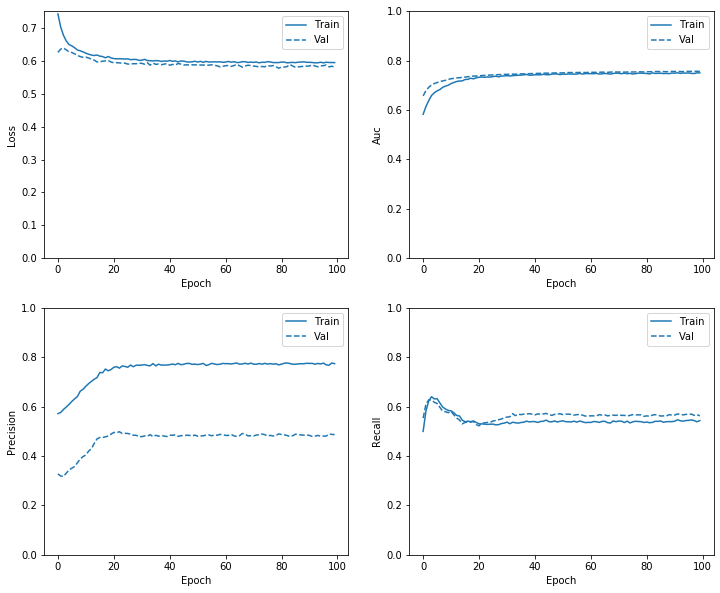

In [100]:
plot_metrics(resampled_history )

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `callbacks.EarlyStopping` finer control over when to stop training.

In [101]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - ETA: 42s - loss: 0.7470 - tp: 463.0000 - fp: 356.0000 - tn: 676.0000 - fn: 553.0000 - accuracy: 0.5562 - precision: 0.5653 - recall: 0.4557 - auc: 0.57 - ETA: 6s - loss: 0.7631 - tp: 2320.0000 - fp: 1858.0000 - tn: 3280.0000 - fn: 2782.0000 - accuracy: 0.5469 - precision: 0.5553 - recall: 0.4547 - auc: 0.562 - ETA: 4s - loss: 0.7586 - tp: 3315.0000 - fp: 2591.0000 - tn: 4572.0000 - fn: 3858.0000 - accuracy: 0.5502 - precision: 0.5613 - recall: 0.4621 - auc: 0.567 - ETA: 2s - loss: 0.7581 - tp: 4280.0000 - fp: 3341.0000 - tn: 5863.0000 - fn: 4948.0000 - accuracy: 0.5503 - precision: 0.5616 - recall: 0.4638 - auc: 0.567 - ETA: 2s - loss: 0.7571 - tp: 5360.0000 - fp: 4084.0000 - tn: 7076.0000 - fn: 6008.0000 - accuracy: 0.5520 - precision: 0.5676 - recall: 0.4715 - auc: 0.571 - ETA: 1s - loss: 0.7543 - tp: 6409.0000 - fp: 4877.0000 - tn: 8343.0000 - fn: 6995.0000 - accuracy: 0.5541 - precision: 0.5679 - recall: 0.4781 - auc: 0.573 - ET

20/20 [==============================] - ETA: 0s - loss: 0.6566 - tp: 640.0000 - fp: 435.0000 - tn: 597.0000 - fn: 376.0000 - accuracy: 0.6040 - precision: 0.5953 - recall: 0.6299 - auc: 0.659 - ETA: 0s - loss: 0.6669 - tp: 2523.0000 - fp: 1750.0000 - tn: 2393.0000 - fn: 1526.0000 - accuracy: 0.6001 - precision: 0.5905 - recall: 0.6231 - auc: 0.648 - ETA: 0s - loss: 0.6635 - tp: 3828.0000 - fp: 2619.0000 - tn: 3567.0000 - fn: 2274.0000 - accuracy: 0.6018 - precision: 0.5938 - recall: 0.6273 - auc: 0.653 - ETA: 0s - loss: 0.6606 - tp: 5113.0000 - fp: 3491.0000 - tn: 4781.0000 - fn: 2999.0000 - accuracy: 0.6039 - precision: 0.5943 - recall: 0.6303 - auc: 0.657 - ETA: 0s - loss: 0.6596 - tp: 6381.0000 - fp: 4369.0000 - tn: 5977.0000 - fn: 3753.0000 - accuracy: 0.6034 - precision: 0.5936 - recall: 0.6297 - auc: 0.657 - ETA: 0s - loss: 0.6587 - tp: 7665.0000 - fp: 5230.0000 - tn: 7191.0000 - fn: 4490.0000 - accuracy: 0.6045 - precision: 0.5944 - recall: 0.6306 - auc: 0.658 - ETA: 0s - loss:

20/20 [==============================] - ETA: 0s - loss: 0.6485 - tp: 601.0000 - fp: 348.0000 - tn: 641.0000 - fn: 458.0000 - accuracy: 0.6064 - precision: 0.6333 - recall: 0.5675 - auc: 0.664 - ETA: 0s - loss: 0.6363 - tp: 2445.0000 - fp: 1330.0000 - tn: 2704.0000 - fn: 1713.0000 - accuracy: 0.6285 - precision: 0.6477 - recall: 0.5880 - auc: 0.685 - ETA: 0s - loss: 0.6361 - tp: 3670.0000 - fp: 2050.0000 - tn: 4057.0000 - fn: 2511.0000 - accuracy: 0.6288 - precision: 0.6416 - recall: 0.5938 - auc: 0.686 - ETA: 0s - loss: 0.6376 - tp: 4855.0000 - fp: 2776.0000 - tn: 5430.0000 - fn: 3323.0000 - accuracy: 0.6277 - precision: 0.6362 - recall: 0.5937 - auc: 0.683 - ETA: 0s - loss: 0.6368 - tp: 6097.0000 - fp: 3410.0000 - tn: 6853.0000 - fn: 4120.0000 - accuracy: 0.6323 - precision: 0.6413 - recall: 0.5968 - auc: 0.687 - ETA: 0s - loss: 0.6352 - tp: 7316.0000 - fp: 4115.0000 - tn: 8255.0000 - fn: 4890.0000 - accuracy: 0.6336 - precision: 0.6400 - recall: 0.5994 - auc: 0.689 - ETA: 0s - loss:

20/20 [==============================] - ETA: 0s - loss: 0.6329 - tp: 582.0000 - fp: 304.0000 - tn: 757.0000 - fn: 405.0000 - accuracy: 0.6538 - precision: 0.6569 - recall: 0.5897 - auc: 0.702 - ETA: 0s - loss: 0.6241 - tp: 2361.0000 - fp: 1146.0000 - tn: 2981.0000 - fn: 1704.0000 - accuracy: 0.6521 - precision: 0.6732 - recall: 0.5808 - auc: 0.706 - ETA: 0s - loss: 0.6253 - tp: 3501.0000 - fp: 1739.0000 - tn: 4479.0000 - fn: 2569.0000 - accuracy: 0.6494 - precision: 0.6681 - recall: 0.5768 - auc: 0.703 - ETA: 0s - loss: 0.6233 - tp: 4710.0000 - fp: 2306.0000 - tn: 5956.0000 - fn: 3412.0000 - accuracy: 0.6510 - precision: 0.6713 - recall: 0.5799 - auc: 0.705 - ETA: 0s - loss: 0.6228 - tp: 5956.0000 - fp: 2885.0000 - tn: 7401.0000 - fn: 4238.0000 - accuracy: 0.6522 - precision: 0.6737 - recall: 0.5843 - auc: 0.707 - ETA: 0s - loss: 0.6225 - tp: 7157.0000 - fp: 3446.0000 - tn: 8889.0000 - fn: 5084.0000 - accuracy: 0.6529 - precision: 0.6750 - recall: 0.5847 - auc: 0.707 - ETA: 0s - loss:

20/20 [==============================] - ETA: 0s - loss: 0.6094 - tp: 572.0000 - fp: 233.0000 - tn: 802.0000 - fn: 441.0000 - accuracy: 0.6709 - precision: 0.7106 - recall: 0.5647 - auc: 0.725 - ETA: 0s - loss: 0.6136 - tp: 2242.0000 - fp: 927.0000 - tn: 3227.0000 - fn: 1796.0000 - accuracy: 0.6676 - precision: 0.7075 - recall: 0.5552 - auc: 0.71 - ETA: 0s - loss: 0.6135 - tp: 3381.0000 - fp: 1372.0000 - tn: 4854.0000 - fn: 2681.0000 - accuracy: 0.6702 - precision: 0.7113 - recall: 0.5577 - auc: 0.717 - ETA: 0s - loss: 0.6128 - tp: 4473.0000 - fp: 1785.0000 - tn: 6527.0000 - fn: 3599.0000 - accuracy: 0.6714 - precision: 0.7148 - recall: 0.5541 - auc: 0.718 - ETA: 0s - loss: 0.6132 - tp: 5565.0000 - fp: 2197.0000 - tn: 8199.0000 - fn: 4519.0000 - accuracy: 0.6721 - precision: 0.7170 - recall: 0.5519 - auc: 0.719 - ETA: 0s - loss: 0.6138 - tp: 6712.0000 - fp: 2642.0000 - tn: 9764.0000 - fn: 5458.0000 - accuracy: 0.6704 - precision: 0.7176 - recall: 0.5515 - auc: 0.718 - ETA: 0s - loss: 0

20/20 [==============================] - ETA: 0s - loss: 0.6036 - tp: 558.0000 - fp: 195.0000 - tn: 843.0000 - fn: 452.0000 - accuracy: 0.6841 - precision: 0.7410 - recall: 0.5525 - auc: 0.732 - ETA: 0s - loss: 0.6136 - tp: 2185.0000 - fp: 777.0000 - tn: 3321.0000 - fn: 1909.0000 - accuracy: 0.6721 - precision: 0.7377 - recall: 0.5337 - auc: 0.71 - ETA: 0s - loss: 0.6129 - tp: 3277.0000 - fp: 1176.0000 - tn: 4976.0000 - fn: 2859.0000 - accuracy: 0.6716 - precision: 0.7359 - recall: 0.5341 - auc: 0.719 - ETA: 0s - loss: 0.6138 - tp: 4381.0000 - fp: 1565.0000 - tn: 6646.0000 - fn: 3792.0000 - accuracy: 0.6730 - precision: 0.7368 - recall: 0.5360 - auc: 0.721 - ETA: 0s - loss: 0.6136 - tp: 5512.0000 - fp: 1943.0000 - tn: 8313.0000 - fn: 4712.0000 - accuracy: 0.6750 - precision: 0.7394 - recall: 0.5391 - auc: 0.723 - ETA: 0s - loss: 0.6121 - tp: 6619.0000 - fp: 2294.0000 - tn: 9989.0000 - fn: 5674.0000 - accuracy: 0.6758 - precision: 0.7426 - recall: 0.5384 - auc: 0.725 - ETA: 0s - loss: 0

20/20 [==============================] - ETA: 0s - loss: 0.6113 - tp: 551.0000 - fp: 200.0000 - tn: 849.0000 - fn: 448.0000 - accuracy: 0.6836 - precision: 0.7337 - recall: 0.5516 - auc: 0.730 - ETA: 0s - loss: 0.6083 - tp: 2191.0000 - fp: 730.0000 - tn: 3406.0000 - fn: 1865.0000 - accuracy: 0.6832 - precision: 0.7501 - recall: 0.5402 - auc: 0.73 - ETA: 0s - loss: 0.6079 - tp: 3289.0000 - fp: 1032.0000 - tn: 5113.0000 - fn: 2854.0000 - accuracy: 0.6838 - precision: 0.7612 - recall: 0.5354 - auc: 0.736 - ETA: 0s - loss: 0.6089 - tp: 4391.0000 - fp: 1377.0000 - tn: 6803.0000 - fn: 3813.0000 - accuracy: 0.6832 - precision: 0.7613 - recall: 0.5352 - auc: 0.734 - ETA: 0s - loss: 0.6082 - tp: 5464.0000 - fp: 1716.0000 - tn: 8516.0000 - fn: 4784.0000 - accuracy: 0.6826 - precision: 0.7610 - recall: 0.5332 - auc: 0.734 - ETA: 0s - loss: 0.6087 - tp: 6550.0000 - fp: 2054.0000 - tn: 10255.0000 - fn: 5717.0000 - accuracy: 0.6838 - precision: 0.7613 - recall: 0.5340 - auc: 0.73 - ETA: 0s - loss: 0

20/20 [==============================] - ETA: 0s - loss: 0.5953 - tp: 563.0000 - fp: 169.0000 - tn: 847.0000 - fn: 469.0000 - accuracy: 0.6885 - precision: 0.7691 - recall: 0.5455 - auc: 0.751 - ETA: 0s - loss: 0.6057 - tp: 2186.0000 - fp: 678.0000 - tn: 3451.0000 - fn: 1877.0000 - accuracy: 0.6881 - precision: 0.7633 - recall: 0.5380 - auc: 0.73 - ETA: 0s - loss: 0.6065 - tp: 3301.0000 - fp: 1031.0000 - tn: 5110.0000 - fn: 2846.0000 - accuracy: 0.6845 - precision: 0.7620 - recall: 0.5370 - auc: 0.733 - ETA: 0s - loss: 0.6080 - tp: 4353.0000 - fp: 1376.0000 - tn: 6836.0000 - fn: 3819.0000 - accuracy: 0.6829 - precision: 0.7598 - recall: 0.5327 - auc: 0.732 - ETA: 0s - loss: 0.6075 - tp: 5417.0000 - fp: 1719.0000 - tn: 8581.0000 - fn: 4763.0000 - accuracy: 0.6835 - precision: 0.7591 - recall: 0.5321 - auc: 0.733 - ETA: 0s - loss: 0.6077 - tp: 6477.0000 - fp: 2063.0000 - tn: 10309.0000 - fn: 5727.0000 - accuracy: 0.6830 - precision: 0.7584 - recall: 0.5307 - auc: 0.73 - ETA: 0s - loss: 0

20/20 [==============================] - ETA: 0s - loss: 0.6132 - tp: 517.0000 - fp: 180.0000 - tn: 831.0000 - fn: 520.0000 - accuracy: 0.6582 - precision: 0.7418 - recall: 0.4986 - auc: 0.714 - ETA: 0s - loss: 0.6066 - tp: 2162.0000 - fp: 709.0000 - tn: 3378.0000 - fn: 1943.0000 - accuracy: 0.6763 - precision: 0.7530 - recall: 0.5267 - auc: 0.72 - ETA: 0s - loss: 0.6036 - tp: 3278.0000 - fp: 1022.0000 - tn: 5043.0000 - fn: 2945.0000 - accuracy: 0.6772 - precision: 0.7623 - recall: 0.5268 - auc: 0.734 - ETA: 0s - loss: 0.6068 - tp: 4320.0000 - fp: 1378.0000 - tn: 6771.0000 - fn: 3915.0000 - accuracy: 0.6769 - precision: 0.7582 - recall: 0.5246 - auc: 0.732 - ETA: 0s - loss: 0.6050 - tp: 5417.0000 - fp: 1684.0000 - tn: 8478.0000 - fn: 4901.0000 - accuracy: 0.6785 - precision: 0.7629 - recall: 0.5250 - auc: 0.733 - ETA: 0s - loss: 0.6064 - tp: 6481.0000 - fp: 2010.0000 - tn: 10214.0000 - fn: 5871.0000 - accuracy: 0.6793 - precision: 0.7633 - recall: 0.5247 - auc: 0.73 - ETA: 0s - loss: 0

20/20 [==============================] - ETA: 0s - loss: 0.6049 - tp: 522.0000 - fp: 171.0000 - tn: 878.0000 - fn: 477.0000 - accuracy: 0.6836 - precision: 0.7532 - recall: 0.5225 - auc: 0.743 - ETA: 0s - loss: 0.6026 - tp: 2141.0000 - fp: 631.0000 - tn: 3484.0000 - fn: 1936.0000 - accuracy: 0.6866 - precision: 0.7724 - recall: 0.5251 - auc: 0.73 - ETA: 0s - loss: 0.6031 - tp: 3219.0000 - fp: 961.0000 - tn: 5193.0000 - fn: 2915.0000 - accuracy: 0.6846 - precision: 0.7701 - recall: 0.5248 - auc: 0.73 - ETA: 0s - loss: 0.6024 - tp: 4300.0000 - fp: 1268.0000 - tn: 6922.0000 - fn: 3894.0000 - accuracy: 0.6849 - precision: 0.7723 - recall: 0.5248 - auc: 0.737 - ETA: 0s - loss: 0.6012 - tp: 5404.0000 - fp: 1610.0000 - tn: 8645.0000 - fn: 4821.0000 - accuracy: 0.6860 - precision: 0.7705 - recall: 0.5285 - auc: 0.739 - ETA: 0s - loss: 0.6017 - tp: 6473.0000 - fp: 1935.0000 - tn: 10388.0000 - fn: 5780.0000 - accuracy: 0.6861 - precision: 0.7699 - recall: 0.5283 - auc: 0.73 - ETA: 0s - loss: 0.6

20/20 [==============================] - ETA: 0s - loss: 0.6010 - tp: 527.0000 - fp: 181.0000 - tn: 867.0000 - fn: 473.0000 - accuracy: 0.6807 - precision: 0.7444 - recall: 0.5270 - auc: 0.731 - ETA: 0s - loss: 0.6010 - tp: 2205.0000 - fp: 676.0000 - tn: 3411.0000 - fn: 1900.0000 - accuracy: 0.6855 - precision: 0.7654 - recall: 0.5371 - auc: 0.73 - ETA: 0s - loss: 0.5992 - tp: 3334.0000 - fp: 985.0000 - tn: 5132.0000 - fn: 2837.0000 - accuracy: 0.6890 - precision: 0.7719 - recall: 0.5403 - auc: 0.74 - ETA: 0s - loss: 0.5972 - tp: 4432.0000 - fp: 1289.0000 - tn: 6890.0000 - fn: 3773.0000 - accuracy: 0.6910 - precision: 0.7747 - recall: 0.5402 - auc: 0.742 - ETA: 0s - loss: 0.5967 - tp: 5555.0000 - fp: 1625.0000 - tn: 8590.0000 - fn: 4710.0000 - accuracy: 0.6907 - precision: 0.7737 - recall: 0.5412 - auc: 0.742 - ETA: 0s - loss: 0.5993 - tp: 6622.0000 - fp: 1994.0000 - tn: 10280.0000 - fn: 5680.0000 - accuracy: 0.6877 - precision: 0.7686 - recall: 0.5383 - auc: 0.73 - ETA: 0s - loss: 0.6

20/20 [==============================] - ETA: 0s - loss: 0.6191 - tp: 526.0000 - fp: 203.0000 - tn: 852.0000 - fn: 467.0000 - accuracy: 0.6729 - precision: 0.7215 - recall: 0.5297 - auc: 0.730 - ETA: 0s - loss: 0.6094 - tp: 2137.0000 - fp: 710.0000 - tn: 3409.0000 - fn: 1936.0000 - accuracy: 0.6770 - precision: 0.7506 - recall: 0.5247 - auc: 0.73 - ETA: 0s - loss: 0.6092 - tp: 3254.0000 - fp: 1055.0000 - tn: 5084.0000 - fn: 2895.0000 - accuracy: 0.6785 - precision: 0.7552 - recall: 0.5292 - auc: 0.733 - ETA: 0s - loss: 0.6039 - tp: 4360.0000 - fp: 1363.0000 - tn: 6836.0000 - fn: 3825.0000 - accuracy: 0.6833 - precision: 0.7618 - recall: 0.5327 - auc: 0.738 - ETA: 0s - loss: 0.6030 - tp: 5426.0000 - fp: 1655.0000 - tn: 8589.0000 - fn: 4810.0000 - accuracy: 0.6843 - precision: 0.7663 - recall: 0.5301 - auc: 0.738 - ETA: 0s - loss: 0.6023 - tp: 6549.0000 - fp: 1972.0000 - tn: 10280.0000 - fn: 5775.0000 - accuracy: 0.6848 - precision: 0.7686 - recall: 0.5314 - auc: 0.73 - ETA: 0s - loss: 0

20/20 [==============================] - ETA: 0s - loss: 0.5932 - tp: 546.0000 - fp: 157.0000 - tn: 863.0000 - fn: 482.0000 - accuracy: 0.6880 - precision: 0.7767 - recall: 0.5311 - auc: 0.746 - ETA: 0s - loss: 0.6009 - tp: 2231.0000 - fp: 669.0000 - tn: 3367.0000 - fn: 1925.0000 - accuracy: 0.6833 - precision: 0.7693 - recall: 0.5368 - auc: 0.73 - ETA: 0s - loss: 0.5972 - tp: 3355.0000 - fp: 972.0000 - tn: 5121.0000 - fn: 2840.0000 - accuracy: 0.6898 - precision: 0.7754 - recall: 0.5416 - auc: 0.74 - ETA: 0s - loss: 0.5983 - tp: 4425.0000 - fp: 1291.0000 - tn: 6859.0000 - fn: 3809.0000 - accuracy: 0.6887 - precision: 0.7741 - recall: 0.5374 - auc: 0.744 - ETA: 0s - loss: 0.5980 - tp: 5565.0000 - fp: 1624.0000 - tn: 8535.0000 - fn: 4756.0000 - accuracy: 0.6885 - precision: 0.7741 - recall: 0.5392 - auc: 0.745 - ETA: 0s - loss: 0.5986 - tp: 6660.0000 - fp: 1980.0000 - tn: 10222.0000 - fn: 5714.0000 - accuracy: 0.6869 - precision: 0.7708 - recall: 0.5382 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.6124 - tp: 516.0000 - fp: 160.0000 - tn: 867.0000 - fn: 505.0000 - accuracy: 0.6753 - precision: 0.7633 - recall: 0.5054 - auc: 0.722 - ETA: 0s - loss: 0.5955 - tp: 2225.0000 - fp: 621.0000 - tn: 3419.0000 - fn: 1927.0000 - accuracy: 0.6890 - precision: 0.7818 - recall: 0.5359 - auc: 0.74 - ETA: 0s - loss: 0.5958 - tp: 3315.0000 - fp: 949.0000 - tn: 5123.0000 - fn: 2901.0000 - accuracy: 0.6867 - precision: 0.7774 - recall: 0.5333 - auc: 0.74 - ETA: 0s - loss: 0.5945 - tp: 4421.0000 - fp: 1261.0000 - tn: 6887.0000 - fn: 3815.0000 - accuracy: 0.6902 - precision: 0.7781 - recall: 0.5368 - auc: 0.745 - ETA: 0s - loss: 0.5954 - tp: 5545.0000 - fp: 1580.0000 - tn: 8600.0000 - fn: 4755.0000 - accuracy: 0.6907 - precision: 0.7782 - recall: 0.5383 - auc: 0.744 - ETA: 0s - loss: 0.5954 - tp: 6607.0000 - fp: 1910.0000 - tn: 10367.0000 - fn: 5692.0000 - accuracy: 0.6907 - precision: 0.7757 - recall: 0.5372 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5935 - tp: 533.0000 - fp: 155.0000 - tn: 887.0000 - fn: 473.0000 - accuracy: 0.6934 - precision: 0.7747 - recall: 0.5298 - auc: 0.750 - ETA: 0s - loss: 0.5939 - tp: 2153.0000 - fp: 640.0000 - tn: 3546.0000 - fn: 1853.0000 - accuracy: 0.6957 - precision: 0.7709 - recall: 0.5374 - auc: 0.75 - ETA: 0s - loss: 0.5914 - tp: 3256.0000 - fp: 959.0000 - tn: 5285.0000 - fn: 2788.0000 - accuracy: 0.6951 - precision: 0.7725 - recall: 0.5387 - auc: 0.75 - ETA: 0s - loss: 0.5916 - tp: 4358.0000 - fp: 1258.0000 - tn: 7034.0000 - fn: 3734.0000 - accuracy: 0.6953 - precision: 0.7760 - recall: 0.5386 - auc: 0.751 - ETA: 0s - loss: 0.5953 - tp: 5462.0000 - fp: 1569.0000 - tn: 8724.0000 - fn: 4725.0000 - accuracy: 0.6927 - precision: 0.7768 - recall: 0.5362 - auc: 0.749 - ETA: 0s - loss: 0.5946 - tp: 6604.0000 - fp: 1878.0000 - tn: 10446.0000 - fn: 5648.0000 - accuracy: 0.6938 - precision: 0.7786 - recall: 0.5390 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5870 - tp: 549.0000 - fp: 147.0000 - tn: 885.0000 - fn: 467.0000 - accuracy: 0.7002 - precision: 0.7888 - recall: 0.5404 - auc: 0.752 - ETA: 0s - loss: 0.5893 - tp: 2210.0000 - fp: 649.0000 - tn: 3495.0000 - fn: 1838.0000 - accuracy: 0.6964 - precision: 0.7730 - recall: 0.5459 - auc: 0.74 - ETA: 0s - loss: 0.5932 - tp: 3306.0000 - fp: 998.0000 - tn: 5214.0000 - fn: 2770.0000 - accuracy: 0.6934 - precision: 0.7681 - recall: 0.5441 - auc: 0.74 - ETA: 0s - loss: 0.5949 - tp: 4373.0000 - fp: 1304.0000 - tn: 6989.0000 - fn: 3718.0000 - accuracy: 0.6935 - precision: 0.7703 - recall: 0.5405 - auc: 0.746 - ETA: 0s - loss: 0.5930 - tp: 5467.0000 - fp: 1591.0000 - tn: 8771.0000 - fn: 4651.0000 - accuracy: 0.6952 - precision: 0.7746 - recall: 0.5403 - auc: 0.748 - ETA: 0s - loss: 0.5948 - tp: 6600.0000 - fp: 1901.0000 - tn: 10481.0000 - fn: 5594.0000 - accuracy: 0.6950 - precision: 0.7764 - recall: 0.5412 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.6083 - tp: 542.0000 - fp: 191.0000 - tn: 876.0000 - fn: 439.0000 - accuracy: 0.6924 - precision: 0.7394 - recall: 0.5525 - auc: 0.746 - ETA: 0s - loss: 0.6090 - tp: 2175.0000 - fp: 709.0000 - tn: 3378.0000 - fn: 1930.0000 - accuracy: 0.6779 - precision: 0.7542 - recall: 0.5298 - auc: 0.73 - ETA: 0s - loss: 0.6042 - tp: 3310.0000 - fp: 1012.0000 - tn: 5094.0000 - fn: 2872.0000 - accuracy: 0.6839 - precision: 0.7658 - recall: 0.5354 - auc: 0.736 - ETA: 0s - loss: 0.6017 - tp: 4443.0000 - fp: 1314.0000 - tn: 6756.0000 - fn: 3871.0000 - accuracy: 0.6835 - precision: 0.7718 - recall: 0.5344 - auc: 0.739 - ETA: 0s - loss: 0.6013 - tp: 5551.0000 - fp: 1640.0000 - tn: 8501.0000 - fn: 4788.0000 - accuracy: 0.6861 - precision: 0.7719 - recall: 0.5369 - auc: 0.741 - ETA: 0s - loss: 0.6011 - tp: 6664.0000 - fp: 1983.0000 - tn: 10199.0000 - fn: 5730.0000 - accuracy: 0.6862 - precision: 0.7707 - recall: 0.5377 - auc: 0.74 - ETA: 0s - loss: 0

20/20 [==============================] - ETA: 0s - loss: 0.6089 - tp: 523.0000 - fp: 167.0000 - tn: 896.0000 - fn: 462.0000 - accuracy: 0.6929 - precision: 0.7580 - recall: 0.5310 - auc: 0.732 - ETA: 0s - loss: 0.5962 - tp: 2179.0000 - fp: 646.0000 - tn: 3522.0000 - fn: 1845.0000 - accuracy: 0.6959 - precision: 0.7713 - recall: 0.5415 - auc: 0.74 - ETA: 0s - loss: 0.5991 - tp: 3256.0000 - fp: 966.0000 - tn: 5253.0000 - fn: 2813.0000 - accuracy: 0.6925 - precision: 0.7712 - recall: 0.5365 - auc: 0.74 - ETA: 0s - loss: 0.5965 - tp: 4335.0000 - fp: 1278.0000 - tn: 6994.0000 - fn: 3777.0000 - accuracy: 0.6915 - precision: 0.7723 - recall: 0.5344 - auc: 0.746 - ETA: 0s - loss: 0.5968 - tp: 5431.0000 - fp: 1603.0000 - tn: 8710.0000 - fn: 4736.0000 - accuracy: 0.6905 - precision: 0.7721 - recall: 0.5342 - auc: 0.746 - ETA: 0s - loss: 0.5984 - tp: 6509.0000 - fp: 1914.0000 - tn: 10465.0000 - fn: 5688.0000 - accuracy: 0.6907 - precision: 0.7728 - recall: 0.5337 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5962 - tp: 540.0000 - fp: 164.0000 - tn: 878.0000 - fn: 466.0000 - accuracy: 0.6924 - precision: 0.7670 - recall: 0.5368 - auc: 0.746 - ETA: 0s - loss: 0.5957 - tp: 2195.0000 - fp: 627.0000 - tn: 3459.0000 - fn: 1911.0000 - accuracy: 0.6902 - precision: 0.7778 - recall: 0.5346 - auc: 0.74 - ETA: 0s - loss: 0.5965 - tp: 3320.0000 - fp: 933.0000 - tn: 5158.0000 - fn: 2877.0000 - accuracy: 0.6899 - precision: 0.7806 - recall: 0.5357 - auc: 0.74 - ETA: 0s - loss: 0.5984 - tp: 4370.0000 - fp: 1266.0000 - tn: 6900.0000 - fn: 3848.0000 - accuracy: 0.6879 - precision: 0.7754 - recall: 0.5318 - auc: 0.744 - ETA: 0s - loss: 0.5969 - tp: 5453.0000 - fp: 1578.0000 - tn: 8670.0000 - fn: 4779.0000 - accuracy: 0.6896 - precision: 0.7756 - recall: 0.5329 - auc: 0.745 - ETA: 0s - loss: 0.5974 - tp: 6553.0000 - fp: 1885.0000 - tn: 10365.0000 - fn: 5773.0000 - accuracy: 0.6884 - precision: 0.7766 - recall: 0.5316 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5883 - tp: 548.0000 - fp: 154.0000 - tn: 871.0000 - fn: 475.0000 - accuracy: 0.6929 - precision: 0.7806 - recall: 0.5357 - auc: 0.750 - ETA: 0s - loss: 0.5930 - tp: 2201.0000 - fp: 661.0000 - tn: 3456.0000 - fn: 1874.0000 - accuracy: 0.6906 - precision: 0.7690 - recall: 0.5401 - auc: 0.75 - ETA: 0s - loss: 0.5942 - tp: 3263.0000 - fp: 957.0000 - tn: 5210.0000 - fn: 2858.0000 - accuracy: 0.6895 - precision: 0.7732 - recall: 0.5331 - auc: 0.74 - ETA: 0s - loss: 0.5944 - tp: 4375.0000 - fp: 1286.0000 - tn: 6939.0000 - fn: 3784.0000 - accuracy: 0.6906 - precision: 0.7728 - recall: 0.5362 - auc: 0.747 - ETA: 0s - loss: 0.5934 - tp: 5468.0000 - fp: 1586.0000 - tn: 8696.0000 - fn: 4730.0000 - accuracy: 0.6916 - precision: 0.7752 - recall: 0.5362 - auc: 0.748 - ETA: 0s - loss: 0.5939 - tp: 6536.0000 - fp: 1921.0000 - tn: 10453.0000 - fn: 5666.0000 - accuracy: 0.6913 - precision: 0.7729 - recall: 0.5356 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5977 - tp: 534.0000 - fp: 152.0000 - tn: 868.0000 - fn: 494.0000 - accuracy: 0.6846 - precision: 0.7784 - recall: 0.5195 - auc: 0.738 - ETA: 0s - loss: 0.5885 - tp: 2244.0000 - fp: 571.0000 - tn: 3452.0000 - fn: 1925.0000 - accuracy: 0.6953 - precision: 0.7972 - recall: 0.5383 - auc: 0.75 - ETA: 0s - loss: 0.5897 - tp: 3371.0000 - fp: 896.0000 - tn: 5134.0000 - fn: 2887.0000 - accuracy: 0.6921 - precision: 0.7900 - recall: 0.5387 - auc: 0.75 - ETA: 0s - loss: 0.5913 - tp: 4474.0000 - fp: 1206.0000 - tn: 6878.0000 - fn: 3826.0000 - accuracy: 0.6929 - precision: 0.7877 - recall: 0.5390 - auc: 0.750 - ETA: 0s - loss: 0.5929 - tp: 5552.0000 - fp: 1541.0000 - tn: 8591.0000 - fn: 4796.0000 - accuracy: 0.6906 - precision: 0.7827 - recall: 0.5365 - auc: 0.748 - ETA: 0s - loss: 0.5929 - tp: 6676.0000 - fp: 1881.0000 - tn: 10299.0000 - fn: 5720.0000 - accuracy: 0.6907 - precision: 0.7802 - recall: 0.5386 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.6023 - tp: 514.0000 - fp: 183.0000 - tn: 882.0000 - fn: 469.0000 - accuracy: 0.6816 - precision: 0.7374 - recall: 0.5229 - auc: 0.737 - ETA: 0s - loss: 0.5970 - tp: 2209.0000 - fp: 666.0000 - tn: 3405.0000 - fn: 1912.0000 - accuracy: 0.6853 - precision: 0.7683 - recall: 0.5360 - auc: 0.74 - ETA: 0s - loss: 0.5950 - tp: 3306.0000 - fp: 989.0000 - tn: 5128.0000 - fn: 2865.0000 - accuracy: 0.6864 - precision: 0.7697 - recall: 0.5357 - auc: 0.74 - ETA: 0s - loss: 0.5965 - tp: 4386.0000 - fp: 1332.0000 - tn: 6858.0000 - fn: 3808.0000 - accuracy: 0.6863 - precision: 0.7671 - recall: 0.5353 - auc: 0.744 - ETA: 0s - loss: 0.5966 - tp: 5501.0000 - fp: 1663.0000 - tn: 8565.0000 - fn: 4751.0000 - accuracy: 0.6868 - precision: 0.7679 - recall: 0.5366 - auc: 0.744 - ETA: 0s - loss: 0.5955 - tp: 6617.0000 - fp: 1964.0000 - tn: 10286.0000 - fn: 5709.0000 - accuracy: 0.6878 - precision: 0.7711 - recall: 0.5368 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5842 - tp: 559.0000 - fp: 146.0000 - tn: 874.0000 - fn: 469.0000 - accuracy: 0.6997 - precision: 0.7929 - recall: 0.5438 - auc: 0.755 - ETA: 0s - loss: 0.5948 - tp: 2266.0000 - fp: 623.0000 - tn: 3421.0000 - fn: 1882.0000 - accuracy: 0.6942 - precision: 0.7844 - recall: 0.5463 - auc: 0.74 - ETA: 0s - loss: 0.5971 - tp: 3346.0000 - fp: 956.0000 - tn: 5139.0000 - fn: 2847.0000 - accuracy: 0.6905 - precision: 0.7778 - recall: 0.5403 - auc: 0.74 - ETA: 0s - loss: 0.5959 - tp: 4434.0000 - fp: 1261.0000 - tn: 6869.0000 - fn: 3820.0000 - accuracy: 0.6899 - precision: 0.7786 - recall: 0.5372 - auc: 0.747 - ETA: 0s - loss: 0.5959 - tp: 5568.0000 - fp: 1594.0000 - tn: 8585.0000 - fn: 4733.0000 - accuracy: 0.6911 - precision: 0.7774 - recall: 0.5405 - auc: 0.748 - ETA: 0s - loss: 0.5947 - tp: 6720.0000 - fp: 1900.0000 - tn: 10273.0000 - fn: 5683.0000 - accuracy: 0.6914 - precision: 0.7796 - recall: 0.5418 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5908 - tp: 528.0000 - fp: 156.0000 - tn: 903.0000 - fn: 461.0000 - accuracy: 0.6987 - precision: 0.7719 - recall: 0.5339 - auc: 0.756 - ETA: 0s - loss: 0.5916 - tp: 2197.0000 - fp: 628.0000 - tn: 3512.0000 - fn: 1855.0000 - accuracy: 0.6969 - precision: 0.7777 - recall: 0.5422 - auc: 0.75 - ETA: 0s - loss: 0.5925 - tp: 3317.0000 - fp: 945.0000 - tn: 5210.0000 - fn: 2816.0000 - accuracy: 0.6939 - precision: 0.7783 - recall: 0.5408 - auc: 0.75 - ETA: 0s - loss: 0.5965 - tp: 4418.0000 - fp: 1264.0000 - tn: 6905.0000 - fn: 3797.0000 - accuracy: 0.6911 - precision: 0.7775 - recall: 0.5378 - auc: 0.747 - ETA: 0s - loss: 0.5976 - tp: 5488.0000 - fp: 1592.0000 - tn: 8643.0000 - fn: 4757.0000 - accuracy: 0.6900 - precision: 0.7751 - recall: 0.5357 - auc: 0.747 - ETA: 0s - loss: 0.5964 - tp: 6567.0000 - fp: 1881.0000 - tn: 10427.0000 - fn: 5701.0000 - accuracy: 0.6915 - precision: 0.7773 - recall: 0.5353 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5954 - tp: 587.0000 - fp: 165.0000 - tn: 819.0000 - fn: 477.0000 - accuracy: 0.6865 - precision: 0.7806 - recall: 0.5517 - auc: 0.744 - ETA: 0s - loss: 0.6024 - tp: 2236.0000 - fp: 647.0000 - tn: 3396.0000 - fn: 1913.0000 - accuracy: 0.6875 - precision: 0.7756 - recall: 0.5389 - auc: 0.74 - ETA: 0s - loss: 0.5963 - tp: 3361.0000 - fp: 959.0000 - tn: 5153.0000 - fn: 2815.0000 - accuracy: 0.6929 - precision: 0.7780 - recall: 0.5442 - auc: 0.74 - ETA: 0s - loss: 0.5943 - tp: 4484.0000 - fp: 1271.0000 - tn: 6880.0000 - fn: 3749.0000 - accuracy: 0.6936 - precision: 0.7791 - recall: 0.5446 - auc: 0.748 - ETA: 0s - loss: 0.5972 - tp: 5585.0000 - fp: 1630.0000 - tn: 8540.0000 - fn: 4725.0000 - accuracy: 0.6897 - precision: 0.7741 - recall: 0.5417 - auc: 0.745 - ETA: 0s - loss: 0.5977 - tp: 6694.0000 - fp: 1959.0000 - tn: 10272.0000 - fn: 5651.0000 - accuracy: 0.6903 - precision: 0.7736 - recall: 0.5422 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5924 - tp: 560.0000 - fp: 166.0000 - tn: 852.0000 - fn: 470.0000 - accuracy: 0.6895 - precision: 0.7713 - recall: 0.5437 - auc: 0.755 - ETA: 0s - loss: 0.5925 - tp: 2222.0000 - fp: 647.0000 - tn: 3425.0000 - fn: 1898.0000 - accuracy: 0.6893 - precision: 0.7745 - recall: 0.5393 - auc: 0.75 - ETA: 0s - loss: 0.5908 - tp: 3349.0000 - fp: 942.0000 - tn: 5161.0000 - fn: 2836.0000 - accuracy: 0.6925 - precision: 0.7805 - recall: 0.5415 - auc: 0.75 - ETA: 0s - loss: 0.5932 - tp: 4431.0000 - fp: 1260.0000 - tn: 6901.0000 - fn: 3792.0000 - accuracy: 0.6917 - precision: 0.7786 - recall: 0.5389 - auc: 0.749 - ETA: 0s - loss: 0.5924 - tp: 5537.0000 - fp: 1583.0000 - tn: 8656.0000 - fn: 4704.0000 - accuracy: 0.6930 - precision: 0.7777 - recall: 0.5407 - auc: 0.749 - ETA: 0s - loss: 0.5935 - tp: 6678.0000 - fp: 1930.0000 - tn: 10340.0000 - fn: 5628.0000 - accuracy: 0.6925 - precision: 0.7758 - recall: 0.5427 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.6107 - tp: 535.0000 - fp: 168.0000 - tn: 852.0000 - fn: 493.0000 - accuracy: 0.6772 - precision: 0.7610 - recall: 0.5204 - auc: 0.728 - ETA: 0s - loss: 0.5998 - tp: 2182.0000 - fp: 660.0000 - tn: 3478.0000 - fn: 1872.0000 - accuracy: 0.6909 - precision: 0.7678 - recall: 0.5382 - auc: 0.74 - ETA: 0s - loss: 0.5955 - tp: 3301.0000 - fp: 968.0000 - tn: 5229.0000 - fn: 2790.0000 - accuracy: 0.6942 - precision: 0.7732 - recall: 0.5419 - auc: 0.74 - ETA: 0s - loss: 0.5962 - tp: 4474.0000 - fp: 1281.0000 - tn: 6902.0000 - fn: 3727.0000 - accuracy: 0.6943 - precision: 0.7774 - recall: 0.5455 - auc: 0.747 - ETA: 0s - loss: 0.5956 - tp: 5553.0000 - fp: 1586.0000 - tn: 8634.0000 - fn: 4707.0000 - accuracy: 0.6927 - precision: 0.7778 - recall: 0.5412 - auc: 0.748 - ETA: 0s - loss: 0.5964 - tp: 6662.0000 - fp: 1949.0000 - tn: 10328.0000 - fn: 5637.0000 - accuracy: 0.6913 - precision: 0.7737 - recall: 0.5417 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5929 - tp: 545.0000 - fp: 152.0000 - tn: 873.0000 - fn: 478.0000 - accuracy: 0.6924 - precision: 0.7819 - recall: 0.5327 - auc: 0.741 - ETA: 0s - loss: 0.5868 - tp: 2273.0000 - fp: 625.0000 - tn: 3437.0000 - fn: 1857.0000 - accuracy: 0.6970 - precision: 0.7843 - recall: 0.5504 - auc: 0.75 - ETA: 0s - loss: 0.5891 - tp: 3407.0000 - fp: 966.0000 - tn: 5147.0000 - fn: 2768.0000 - accuracy: 0.6961 - precision: 0.7791 - recall: 0.5517 - auc: 0.75 - ETA: 0s - loss: 0.5914 - tp: 4492.0000 - fp: 1290.0000 - tn: 6908.0000 - fn: 3694.0000 - accuracy: 0.6958 - precision: 0.7769 - recall: 0.5487 - auc: 0.751 - ETA: 0s - loss: 0.5925 - tp: 5586.0000 - fp: 1610.0000 - tn: 8625.0000 - fn: 4659.0000 - accuracy: 0.6939 - precision: 0.7763 - recall: 0.5452 - auc: 0.749 - ETA: 0s - loss: 0.5933 - tp: 6711.0000 - fp: 1946.0000 - tn: 10326.0000 - fn: 5593.0000 - accuracy: 0.6932 - precision: 0.7752 - recall: 0.5454 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5908 - tp: 511.0000 - fp: 150.0000 - tn: 940.0000 - fn: 447.0000 - accuracy: 0.7085 - precision: 0.7731 - recall: 0.5334 - auc: 0.750 - ETA: 0s - loss: 0.5898 - tp: 2185.0000 - fp: 618.0000 - tn: 3556.0000 - fn: 1833.0000 - accuracy: 0.7008 - precision: 0.7795 - recall: 0.5438 - auc: 0.75 - ETA: 0s - loss: 0.5923 - tp: 3283.0000 - fp: 952.0000 - tn: 5273.0000 - fn: 2780.0000 - accuracy: 0.6963 - precision: 0.7752 - recall: 0.5415 - auc: 0.75 - ETA: 0s - loss: 0.5930 - tp: 4384.0000 - fp: 1266.0000 - tn: 7008.0000 - fn: 3726.0000 - accuracy: 0.6953 - precision: 0.7759 - recall: 0.5406 - auc: 0.751 - ETA: 0s - loss: 0.5939 - tp: 5469.0000 - fp: 1601.0000 - tn: 8713.0000 - fn: 4697.0000 - accuracy: 0.6925 - precision: 0.7736 - recall: 0.5380 - auc: 0.749 - ETA: 0s - loss: 0.5947 - tp: 6578.0000 - fp: 1933.0000 - tn: 10429.0000 - fn: 5636.0000 - accuracy: 0.6920 - precision: 0.7729 - recall: 0.5386 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5793 - tp: 547.0000 - fp: 148.0000 - tn: 896.0000 - fn: 457.0000 - accuracy: 0.7046 - precision: 0.7871 - recall: 0.5448 - auc: 0.759 - ETA: 0s - loss: 0.5931 - tp: 2145.0000 - fp: 651.0000 - tn: 3545.0000 - fn: 1851.0000 - accuracy: 0.6946 - precision: 0.7672 - recall: 0.5368 - auc: 0.74 - ETA: 0s - loss: 0.5953 - tp: 3225.0000 - fp: 994.0000 - tn: 5312.0000 - fn: 2757.0000 - accuracy: 0.6947 - precision: 0.7644 - recall: 0.5391 - auc: 0.74 - ETA: 0s - loss: 0.5937 - tp: 4306.0000 - fp: 1311.0000 - tn: 7049.0000 - fn: 3718.0000 - accuracy: 0.6931 - precision: 0.7666 - recall: 0.5366 - auc: 0.747 - ETA: 0s - loss: 0.5921 - tp: 5433.0000 - fp: 1618.0000 - tn: 8759.0000 - fn: 4670.0000 - accuracy: 0.6930 - precision: 0.7705 - recall: 0.5378 - auc: 0.750 - ETA: 0s - loss: 0.5924 - tp: 6509.0000 - fp: 1933.0000 - tn: 10508.0000 - fn: 5626.0000 - accuracy: 0.6924 - precision: 0.7710 - recall: 0.5364 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5867 - tp: 575.0000 - fp: 150.0000 - tn: 837.0000 - fn: 486.0000 - accuracy: 0.6895 - precision: 0.7931 - recall: 0.5419 - auc: 0.761 - ETA: 0s - loss: 0.5870 - tp: 2245.0000 - fp: 609.0000 - tn: 3474.0000 - fn: 1864.0000 - accuracy: 0.6981 - precision: 0.7866 - recall: 0.5464 - auc: 0.75 - ETA: 0s - loss: 0.5910 - tp: 3375.0000 - fp: 924.0000 - tn: 5168.0000 - fn: 2821.0000 - accuracy: 0.6952 - precision: 0.7851 - recall: 0.5447 - auc: 0.75 - ETA: 0s - loss: 0.5912 - tp: 4506.0000 - fp: 1234.0000 - tn: 6842.0000 - fn: 3802.0000 - accuracy: 0.6926 - precision: 0.7850 - recall: 0.5424 - auc: 0.753 - ETA: 0s - loss: 0.5925 - tp: 5602.0000 - fp: 1582.0000 - tn: 8600.0000 - fn: 4696.0000 - accuracy: 0.6935 - precision: 0.7798 - recall: 0.5440 - auc: 0.752 - ETA: 0s - loss: 0.5918 - tp: 6742.0000 - fp: 1893.0000 - tn: 10304.0000 - fn: 5637.0000 - accuracy: 0.6936 - precision: 0.7808 - recall: 0.5446 - auc: 0.75 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5878 - tp: 566.0000 - fp: 155.0000 - tn: 861.0000 - fn: 466.0000 - accuracy: 0.6968 - precision: 0.7850 - recall: 0.5484 - auc: 0.760 - ETA: 0s - loss: 0.5930 - tp: 2218.0000 - fp: 625.0000 - tn: 3478.0000 - fn: 1871.0000 - accuracy: 0.6953 - precision: 0.7802 - recall: 0.5424 - auc: 0.75 - ETA: 0s - loss: 0.5940 - tp: 3290.0000 - fp: 958.0000 - tn: 5204.0000 - fn: 2836.0000 - accuracy: 0.6912 - precision: 0.7745 - recall: 0.5371 - auc: 0.74 - ETA: 0s - loss: 0.5954 - tp: 4426.0000 - fp: 1273.0000 - tn: 6903.0000 - fn: 3782.0000 - accuracy: 0.6915 - precision: 0.7766 - recall: 0.5392 - auc: 0.749 - ETA: 0s - loss: 0.5957 - tp: 5532.0000 - fp: 1586.0000 - tn: 8624.0000 - fn: 4738.0000 - accuracy: 0.6912 - precision: 0.7772 - recall: 0.5387 - auc: 0.748 - ETA: 0s - loss: 0.5947 - tp: 6624.0000 - fp: 1894.0000 - tn: 10364.0000 - fn: 5694.0000 - accuracy: 0.6912 - precision: 0.7776 - recall: 0.5377 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.6018 - tp: 551.0000 - fp: 169.0000 - tn: 831.0000 - fn: 497.0000 - accuracy: 0.6748 - precision: 0.7653 - recall: 0.5258 - auc: 0.738 - ETA: 0s - loss: 0.6015 - tp: 2176.0000 - fp: 689.0000 - tn: 3388.0000 - fn: 1939.0000 - accuracy: 0.6792 - precision: 0.7595 - recall: 0.5288 - auc: 0.74 - ETA: 0s - loss: 0.5994 - tp: 3242.0000 - fp: 1021.0000 - tn: 5176.0000 - fn: 2849.0000 - accuracy: 0.6851 - precision: 0.7605 - recall: 0.5323 - auc: 0.741 - ETA: 0s - loss: 0.5976 - tp: 4347.0000 - fp: 1341.0000 - tn: 6923.0000 - fn: 3773.0000 - accuracy: 0.6879 - precision: 0.7642 - recall: 0.5353 - auc: 0.744 - ETA: 0s - loss: 0.5975 - tp: 5491.0000 - fp: 1676.0000 - tn: 8613.0000 - fn: 4700.0000 - accuracy: 0.6887 - precision: 0.7662 - recall: 0.5388 - auc: 0.746 - ETA: 0s - loss: 0.5956 - tp: 6590.0000 - fp: 1970.0000 - tn: 10362.0000 - fn: 5654.0000 - accuracy: 0.6898 - precision: 0.7699 - recall: 0.5382 - auc: 0.74 - ETA: 0s - loss: 0

20/20 [==============================] - ETA: 0s - loss: 0.5963 - tp: 550.0000 - fp: 165.0000 - tn: 855.0000 - fn: 478.0000 - accuracy: 0.6860 - precision: 0.7692 - recall: 0.5350 - auc: 0.732 - ETA: 0s - loss: 0.5951 - tp: 2226.0000 - fp: 670.0000 - tn: 3360.0000 - fn: 1936.0000 - accuracy: 0.6819 - precision: 0.7686 - recall: 0.5348 - auc: 0.74 - ETA: 0s - loss: 0.5975 - tp: 3353.0000 - fp: 998.0000 - tn: 5042.0000 - fn: 2895.0000 - accuracy: 0.6832 - precision: 0.7706 - recall: 0.5367 - auc: 0.74 - ETA: 0s - loss: 0.5955 - tp: 4427.0000 - fp: 1325.0000 - tn: 6810.0000 - fn: 3822.0000 - accuracy: 0.6859 - precision: 0.7696 - recall: 0.5367 - auc: 0.746 - ETA: 0s - loss: 0.5939 - tp: 5564.0000 - fp: 1654.0000 - tn: 8526.0000 - fn: 4736.0000 - accuracy: 0.6880 - precision: 0.7709 - recall: 0.5402 - auc: 0.748 - ETA: 0s - loss: 0.5935 - tp: 6660.0000 - fp: 2014.0000 - tn: 10270.0000 - fn: 5632.0000 - accuracy: 0.6889 - precision: 0.7678 - recall: 0.5418 - auc: 0.74 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5955 - tp: 585.0000 - fp: 156.0000 - tn: 814.0000 - fn: 493.0000 - accuracy: 0.6831 - precision: 0.7895 - recall: 0.5427 - auc: 0.747 - ETA: 0s - loss: 0.5911 - tp: 2255.0000 - fp: 644.0000 - tn: 3394.0000 - fn: 1899.0000 - accuracy: 0.6896 - precision: 0.7779 - recall: 0.5429 - auc: 0.75 - ETA: 0s - loss: 0.5943 - tp: 3375.0000 - fp: 986.0000 - tn: 5137.0000 - fn: 2790.0000 - accuracy: 0.6927 - precision: 0.7739 - recall: 0.5474 - auc: 0.75 - ETA: 0s - loss: 0.5923 - tp: 4481.0000 - fp: 1310.0000 - tn: 6890.0000 - fn: 3703.0000 - accuracy: 0.6940 - precision: 0.7738 - recall: 0.5475 - auc: 0.754 - ETA: 0s - loss: 0.5913 - tp: 5601.0000 - fp: 1658.0000 - tn: 8606.0000 - fn: 4615.0000 - accuracy: 0.6937 - precision: 0.7716 - recall: 0.5483 - auc: 0.754 - ETA: 0s - loss: 0.5925 - tp: 6709.0000 - fp: 1995.0000 - tn: 10304.0000 - fn: 5568.0000 - accuracy: 0.6923 - precision: 0.7708 - recall: 0.5465 - auc: 0.75 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5780 - tp: 579.0000 - fp: 152.0000 - tn: 869.0000 - fn: 448.0000 - accuracy: 0.7070 - precision: 0.7921 - recall: 0.5638 - auc: 0.767 - ETA: 0s - loss: 0.5875 - tp: 2217.0000 - fp: 618.0000 - tn: 3507.0000 - fn: 1850.0000 - accuracy: 0.6987 - precision: 0.7820 - recall: 0.5451 - auc: 0.75 - ETA: 0s - loss: 0.5915 - tp: 3328.0000 - fp: 971.0000 - tn: 5212.0000 - fn: 2777.0000 - accuracy: 0.6950 - precision: 0.7741 - recall: 0.5451 - auc: 0.75 - ETA: 0s - loss: 0.5930 - tp: 4456.0000 - fp: 1329.0000 - tn: 6892.0000 - fn: 3707.0000 - accuracy: 0.6926 - precision: 0.7703 - recall: 0.5459 - auc: 0.750 - ETA: 0s - loss: 0.5927 - tp: 5593.0000 - fp: 1665.0000 - tn: 8635.0000 - fn: 4587.0000 - accuracy: 0.6947 - precision: 0.7706 - recall: 0.5494 - auc: 0.750 - ETA: 0s - loss: 0.5925 - tp: 6736.0000 - fp: 1978.0000 - tn: 10330.0000 - fn: 5532.0000 - accuracy: 0.6944 - precision: 0.7730 - recall: 0.5491 - auc: 0.75 - ETA: 0s - loss: 0.5

20/20 [==============================] - ETA: 0s - loss: 0.5959 - tp: 574.0000 - fp: 185.0000 - tn: 830.0000 - fn: 459.0000 - accuracy: 0.6855 - precision: 0.7563 - recall: 0.5557 - auc: 0.743 - ETA: 0s - loss: 0.5961 - tp: 2255.0000 - fp: 692.0000 - tn: 3408.0000 - fn: 1837.0000 - accuracy: 0.6913 - precision: 0.7652 - recall: 0.5511 - auc: 0.74 - ETA: 0s - loss: 0.5931 - tp: 3417.0000 - fp: 1004.0000 - tn: 5101.0000 - fn: 2766.0000 - accuracy: 0.6932 - precision: 0.7729 - recall: 0.5526 - auc: 0.749 - ETA: 0s - loss: 0.5912 - tp: 4510.0000 - fp: 1332.0000 - tn: 6848.0000 - fn: 3694.0000 - accuracy: 0.6932 - precision: 0.7720 - recall: 0.5497 - auc: 0.750 - ETA: 0s - loss: 0.5921 - tp: 5610.0000 - fp: 1681.0000 - tn: 8561.0000 - fn: 4628.0000 - accuracy: 0.6919 - precision: 0.7694 - recall: 0.5480 - auc: 0.749 - ETA: 0s - loss: 0.5914 - tp: 6744.0000 - fp: 2002.0000 - tn: 10229.0000 - fn: 5601.0000 - accuracy: 0.6906 - precision: 0.7711 - recall: 0.5463 - auc: 0.75 - ETA: 0s - loss: 0

### Re-check training history

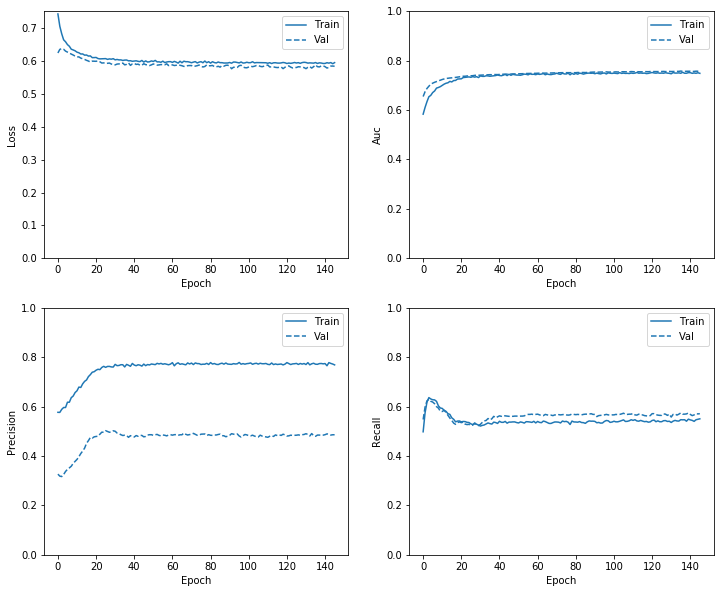

In [102]:
plot_metrics(resampled_history)

### Evaluate metrics

In [103]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.5842010366121928
tp :  784.0
fp :  791.0
tn :  3844.0
fn :  581.0
accuracy :  0.77133334
precision :  0.4977778
recall :  0.574359
auc :  0.7548232

Legitimate Transactions Detected (True Negatives):  3844
Legitimate Transactions Incorrectly Detected (False Positives):  791
Fraudulent Transactions Missed (False Negatives):  581
Fraudulent Transactions Detected (True Positives):  784
Total Fraudulent Transactions:  1365


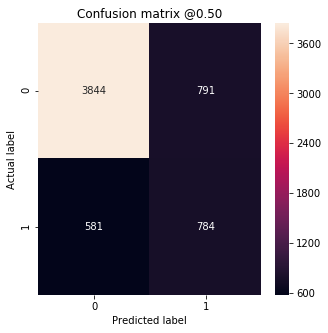

In [104]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

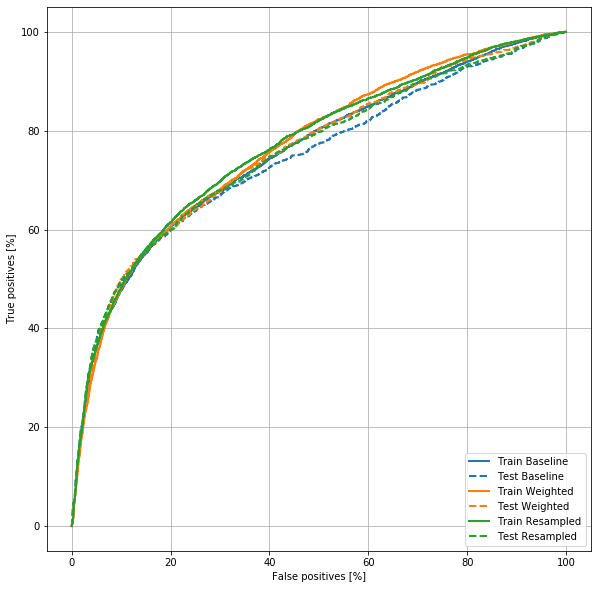

In [105]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

# Random Forest

In [106]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2020

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os

In [107]:
target = 'default.payment.next.month'
predictors = [  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [108]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [109]:
clf.fit(train_features,
    train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=2020, verbose=False,
                       warm_start=False)

In [110]:
preds = clf.predict(test_features)
#test_features, test_labels

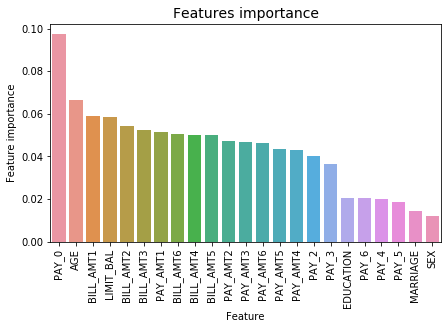

In [111]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

# Evaluation metrics
Let's visualize the confusion matrix.

roc_auc_score 0.666907310596631
Legitimate Transactions Detected (True Negatives):  4352
Legitimate Transactions Incorrectly Detected (False Positives):  283
Fraudulent Transactions Missed (False Negatives):  826
Fraudulent Transactions Detected (True Positives):  539
Total Fraudulent Transactions:  1365


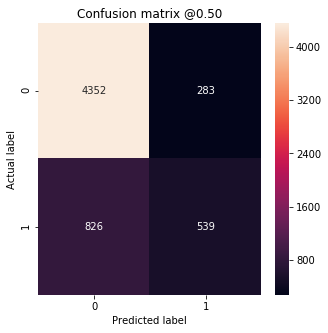

In [112]:
train_predictions= clf.predict(train_features)
test_predictions = clf.predict(test_features)

print('roc_auc_score',roc_auc_score(test_labels, test_predictions))
plot_cm(test_labels, test_predictions)

# XGBOOST

In [113]:
# Prepare the train and valid datasets
train_df, val_df = train_test_split(cleaned_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(val_df[predictors], val_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [114]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[16:05:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69283	valid-auc:0.69741
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.76562	valid-auc:0.77528
[100]	train-auc:0.77585	valid-auc:0.78311
[150]	train-auc:0.78114	valid-auc:0.78664
[200]	train-auc:0.78500	valid-auc:0.78917
[250]	train-auc:0.78807	valid-auc:0.79018
[300]	train-auc:0.79063	valid-auc:0.79053
Stopping. Best iteration:
[295]	train-auc:0.79043	valid-auc:0.79068



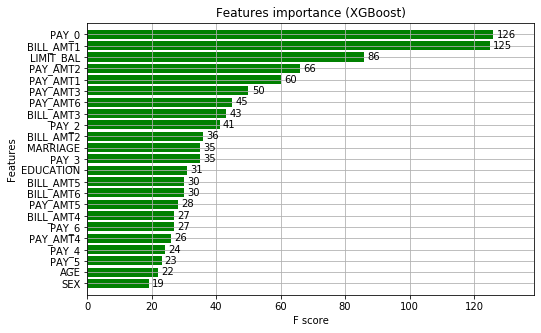

In [115]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

# AdaBoost

In [116]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [117]:
clf.fit(train_features, train_labels)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=2020)

In [118]:
preds = clf.predict(val_df[predictors])

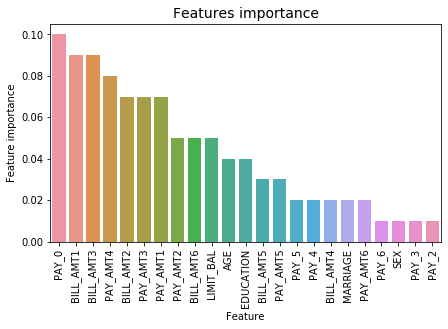

In [119]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

# Evaluation metrics
Let's visualize the confusion matrix.

roc_auc_score 0.6570693599819813
Legitimate Transactions Detected (True Negatives):  4417
Legitimate Transactions Incorrectly Detected (False Positives):  218
Fraudulent Transactions Missed (False Negatives):  872
Fraudulent Transactions Detected (True Positives):  493
Total Fraudulent Transactions:  1365


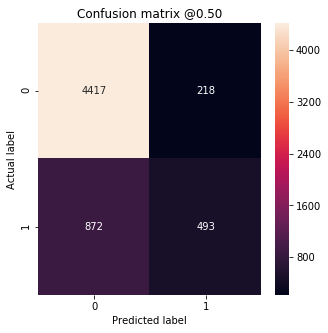

In [120]:
train_predictions= clf.predict(train_features)
test_predictions = clf.predict(test_features)

print('roc_auc_score',roc_auc_score(test_labels, test_predictions))
plot_cm(test_labels, test_predictions)

# LightGBM

In [121]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':50, # because training data is sightly unbalanced 
         }

In [122]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [123]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors,
                     categorical_feature=categorical_features)

dvalid = lgb.Dataset(val_df[predictors].values,
                     label=val_df[target].values,
                     feature_name=predictors,
                     categorical_feature=categorical_features)

In [124]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

del dvalid
gc.collect()

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.778454	valid's auc: 0.783518
[100]	train's auc: 0.788181	valid's auc: 0.7908
[150]	train's auc: 0.793458	valid's auc: 0.791718
[200]	train's auc: 0.798534	valid's auc: 0.791999
[250]	train's auc: 0.802696	valid's auc: 0.790798
Early stopping, best iteration is:
[202]	train's auc: 0.798616	valid's auc: 0.792


106203

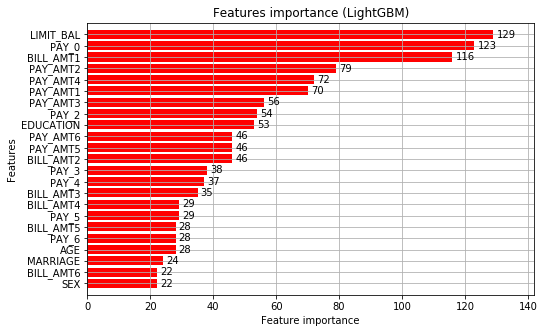

In [125]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

## Training and validation using cross-validation
Let's use now cross-validation. We will use cross-validation (KFolds) with 10 folds. Data is divided in 10 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

In [126]:
kf = KFold(n_splits = 10, random_state = RANDOM_STATE, shuffle = True)
for train_index, test_index in kf.split(raw_df):
    train_X, valid_X = raw_df.iloc[train_index], raw_df.iloc[test_index]

    dtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values,
                     feature_name=predictors)

    dvalid = lgb.Dataset(valid_X[predictors].values, label=valid_X[target].values,
                     feature_name=predictors)

    evals_results = {}
    model =  lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.776831	valid's auc: 0.794662
[100]	train's auc: 0.786346	valid's auc: 0.800176
[150]	train's auc: 0.791996	valid's auc: 0.802208
[200]	train's auc: 0.79744	valid's auc: 0.802797
[250]	train's auc: 0.80119	valid's auc: 0.803254
Early stopping, best iteration is:
[237]	train's auc: 0.800183	valid's auc: 0.803641
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.778176	valid's auc: 0.773759
[100]	train's auc: 0.787656	valid's auc: 0.781473
[150]	train's auc: 0.793712	valid's auc: 0.784656
[200]	train's auc: 0.798218	valid's auc: 0.78488
[250]	train's auc: 0.802721	valid's auc: 0.785273
Early stopping, best iteration is:
[235]	train's auc: 0.801385	valid's auc: 0.785601
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.779836	valid's auc: 0.772424
[100]	train's auc: 0.788955	valid's auc: 0.777707
[150]	train's auc: 0.794749	valid's auc: 0.779265
[20